# This notebook recreates plots in the results section of the paper

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [4]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age)*1e-9

Text(0, 0.5, '$\\log(g)$')

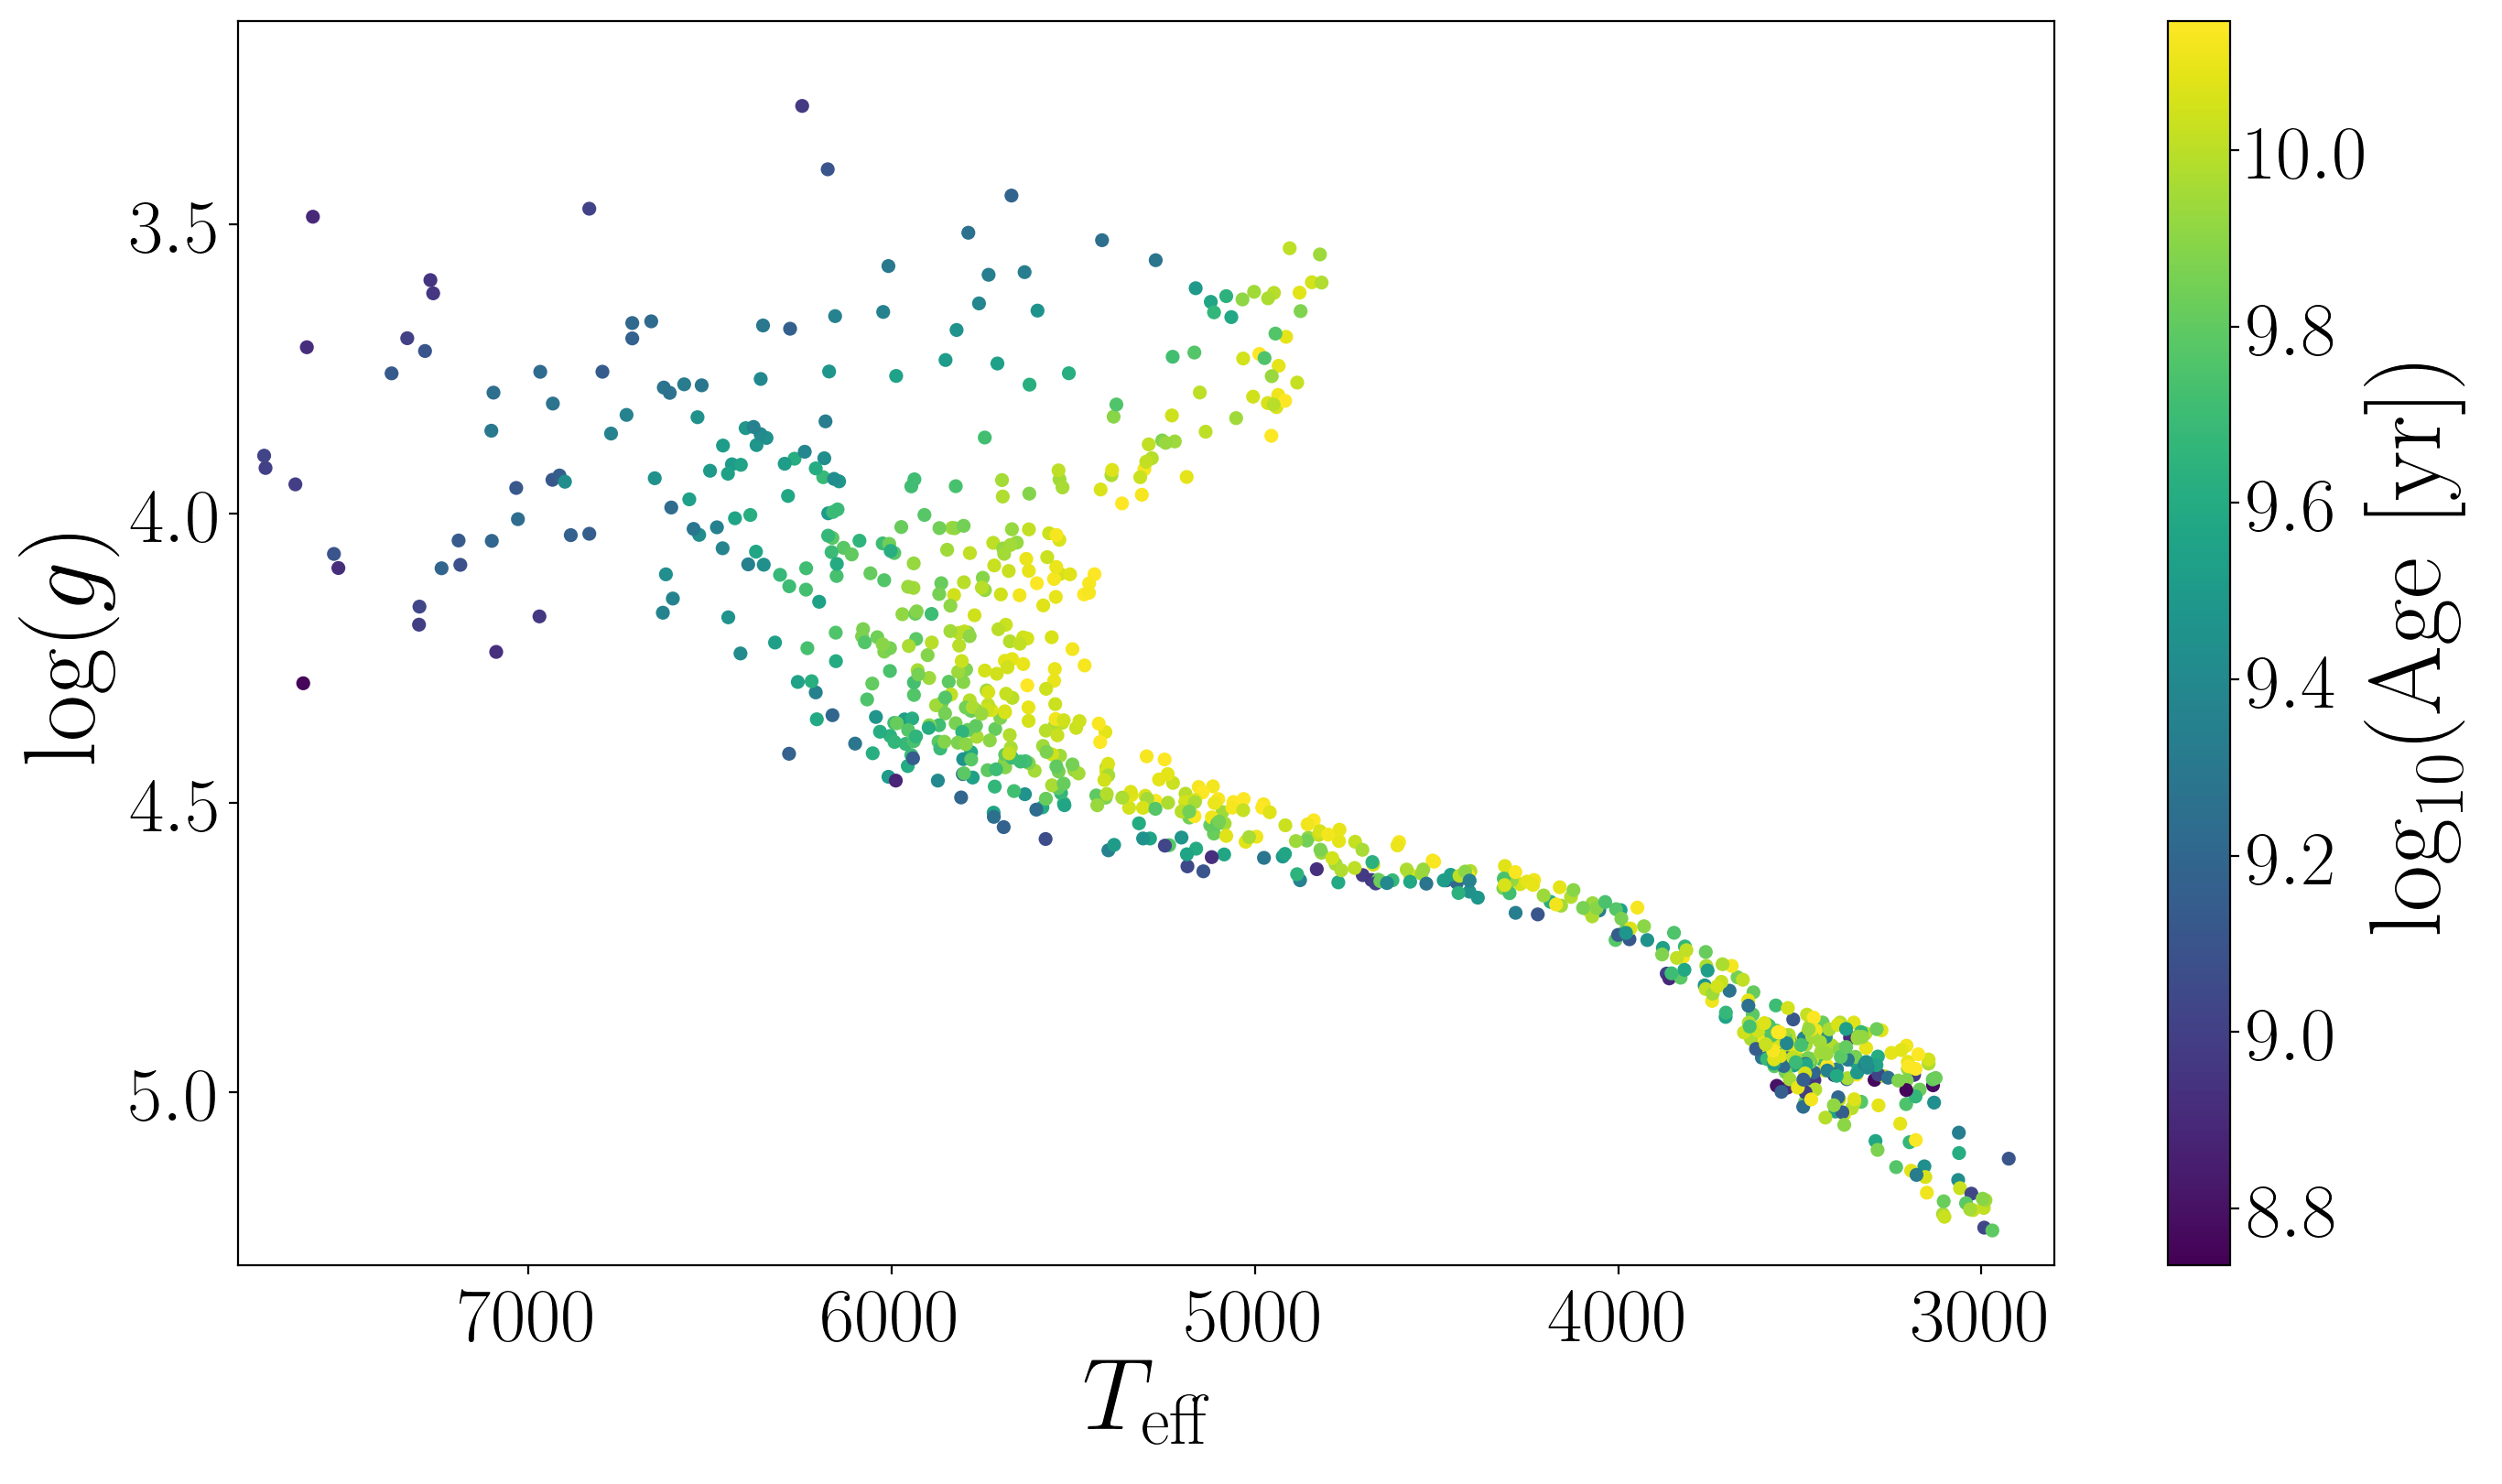

In [5]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
# plt.savefig("../simulated_CMD.pdf")

Plot a corner plot for the first star.

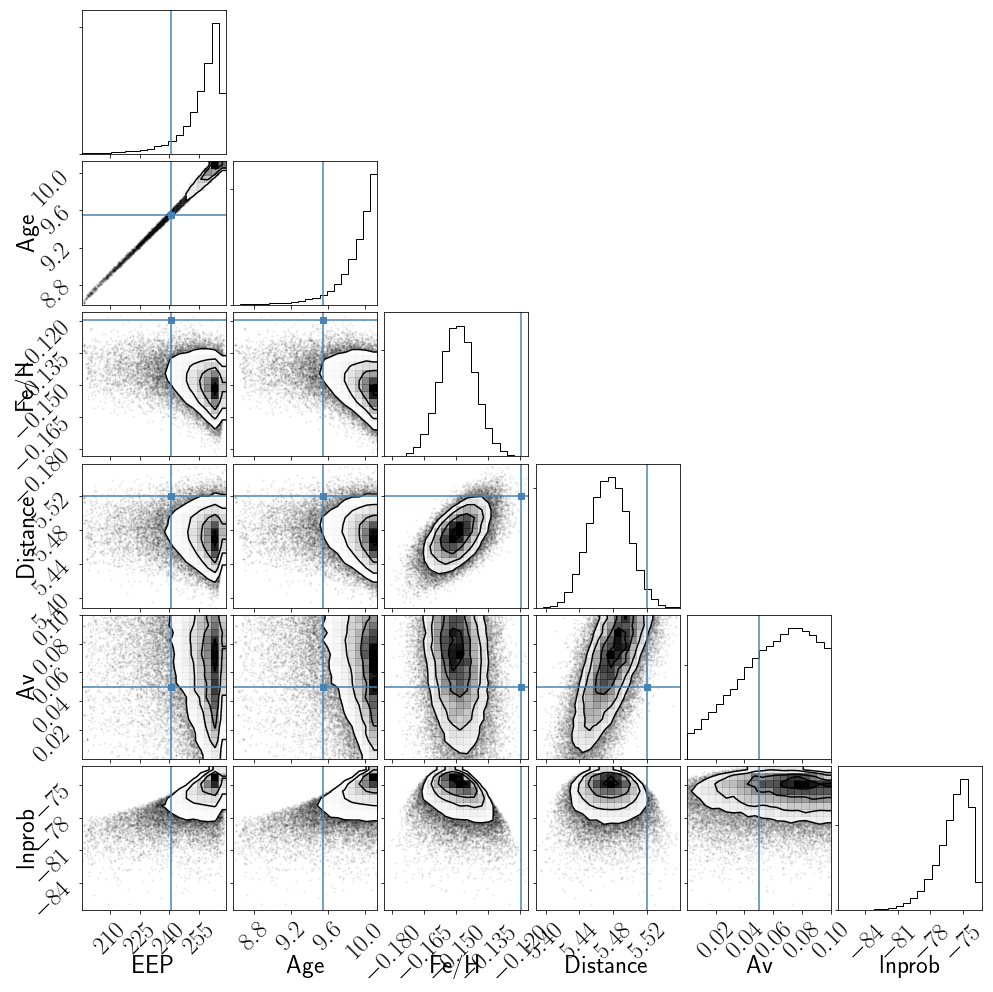

In [375]:
def load_samples(fname, burnin):
    reader = emcee.backends.HDFBackend(fname, read_only=True)
    samples = reader.get_chain()
    lnprobs = reader.get_log_prob()
    nsteps, nwalkers, ndim = np.shape(samples)
    augmented = np.zeros((nsteps, nwalkers, ndim+1))
    augmented[:, :, :-1] = samples
    augmented[:, :, -1] = lnprobs
    nsteps, nwalkers, ndim = np.shape(augmented)
    samps = np.reshape(augmented[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
    return samps

# [ 42  63  87 105 114 138 156 186]
i = 87
fname1 = "simulation_results/{}_iso_prior.h5".format(str(i).zfill(4))
fname2 = "simulation_results/{}_iso.h5".format(str(i).zfill(4))
lnflatprior_samps = load_samples(fname1, 100)
flatprior_samps = load_samples(fname2, 100)

tr = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)),
      df.Av.values[i], None]
labels = ["EEP", "Age", "Fe/H", "Distance", "Av", "lnprob"]
corner.corner(samps, truths=tr, labels=labels);

13.489388681593207


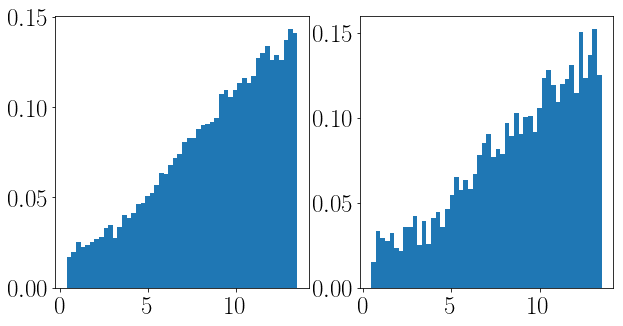

In [380]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist((10**lnflatprior_samps[:, 1])*1e-9, 50, normed=True);
plt.subplot(1, 2, 2)
plt.hist((10**flatprior_samps[:, 1])*1e-9, 50, normed=True);

In [7]:
# plt.hist((10**samps[100:, 1])*1e-9, 50);
# plt.axvline(4.56, color="C1")

# med = (10**np.median(samps[:, 1]))*1e-9
# print(med)
# plt.axvline(med, color="C1", ls="--")

# # plt.hist(samps[:, 1], 50);
# # plt.axvline(np.log10(4.56*1e9), color="C1")

# from isochrones import StarModel, get_ichrone
# bands = ["B", "V", "J", "H", "K", "BP", "RP"]
# mist = get_ichrone("mist", bands=bands)


# from stardate.lhf import lnprob

# iso_params = {"teff": (5777, 10),
#               "logg": (4.44, .05),
#               "feh": (0., .001),
#               "parallax": (1., .01),  # milliarcseconds
#               "B": (15.48, 0.02)}

# # Set up the StarModel isochrones object.
# mod = StarModel(mist, **iso_params)
# # the lnprob arguments]
# args = [mod, 26., 1., False, False, True, "praesepe"]

# sun = [355, np.log10(4.56*1e9), 0., np.log(1000), 0.]
# sun2 = np.median(samps, axis=0)
# print(sun2)

# print(lnprob(sun, *args))
# print(lnprob(sun2, *args))

### And plot the trace.

[330.3255596992683, 9.71024368696882, 0.3584764446262379, 4.539598693150374, 0.05461000558527379]


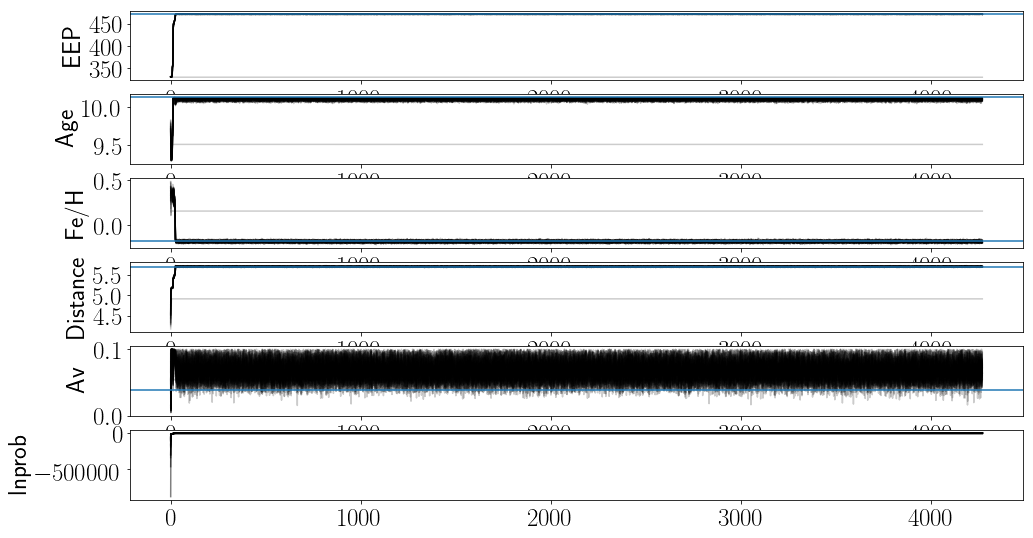

In [275]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.ylabel(labels[j])
    if tr[j] is not None:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
plt.ylabel(labels[5])
print(inits)

Now plot all the results.

In [399]:
from dynesty import utils as dyfunc

def percentiles_from_samps(samps, lp):
    med = np.median(samps)
    max_like = samps[lp == max(lp)][0]

    std = np.std(samps)
    upper = np.percentile(samps, 84)
    lower = np.percentile(samps, 16)
    errp = upper - med
    errm = med - lower
    
    return med, errp, errm, std, max_like


def read_files(name, ids, dirname=".", burnin=100, dynesty=False):
    meds, age_samps, errp, errm, ml, std, inds = [], [], [], [], [], [], []
    eeps, eep_errp, eep_errm, eep_std, eep_ml = [], [], [], [], []
    fehs, feh_errp, feh_errm, feh_std, feh_ml = [], [], [], [], []
    
    for i, ID in enumerate(ids):
        fname = "{0}/{1}_{2}.h5".format(dirname, str(int(ID)).zfill(4), name)

        if dynesty:
            try:
                sample_df = pd.read_hdf(fname)
                samps = sample_df.samples[0]
                weights = sample_df.weights[0]
                
                a, ap, am, _std = percentiles_from_samps((10**samps[burnin:, 1])*1e-9)
                age_samps.append((10**samps[burnin:, 1])*1e-9)
                mean, cov = dyfunc.mean_and_cov(samps, weights)
                meds.append((10**mean[1])*1e-9)
                eeps.append(mean[0])
                errp.append(ap)
                errm.append(am)
                std.append(_std)
                inds.append(i)
            except:
                pass
        
        else:
            try:
                reader = emcee.backends.HDFBackend(fname)
                samples = reader.get_chain()
                lnp = reader.get_log_prob()
            
                if np.shape(samples)[0] > 10:
                    nsteps, nwalkers, ndim = np.shape(samples)
                    samps = np.reshape(samples, (nsteps*nwalkers, ndim))
                    lp = np.reshape(lnp, (nsteps*nwalkers))
            
                    a, ap, am, _std, aml = percentiles_from_samps((10**samps[burnin:, 1])*1e-9, lp[burnin:])
                    e, ep, em, _estd, eml = percentiles_from_samps(samps[burnin:, 0], lp[burnin:])
                    f, fp, fm, _fstd, fml = percentiles_from_samps(samps[burnin:, 2], lp[burnin:])

                    age_samps.append((10**samps[burnin:, 1])*1e-9)
                    
                    eeps.append(e)
                    eep_errp.append(ep)
                    eep_errm.append(em)
                    eep_std.append(_estd)
                    eep_ml.append(eml)
                    
                    fehs.append(f)
                    feh_errp.append(fp)
                    feh_errm.append(fm)
                    feh_std.append(_fstd)
                    feh_ml.append(fml)
                    
                    meds.append(a)
                    errp.append(ap)
                    errm.append(am)
                    std.append(_std)
                    ml.append(aml)
                    inds.append(i)
                    
            except:
                pass
    
    return age_samps, np.array(meds), np.array(errp), np.array(errm), np.array(std), np.array(ml),\
            np.array(eeps), np.array(eep_errp), np.array(eep_errm), np.array(eep_std), np.array(eep_ml),\
            np.array(fehs), np.array(feh_errp), np.array(feh_errm), np.array(feh_std), np.array(feh_ml),\
            np.array(inds)

# age_samps, meds, errp, errm, std, eeps, inds = read_files("stardate_5_dynesty", np.arange(1000),
#                                                     dirname="simulation_results", dynesty=True)
# age_samps, meds, errp, errm, std, eeps, eep_errp, eep_errm, eep_std, inds = read_files(
#     "stardate_p_noise_5", np.arange(1000), dirname="simulation_results")
age_samps, meds, errp, errm, std, ml,\
    eeps, eep_errp, eep_errm, eep_std, eep_ml,\
    fehs, feh_errp, feh_errm, feh_std, feh_ml,\
    inds = read_files("stardate_5_eep", np.arange(1000), dirname="simulation_results")

print(len(inds))

320


Select stars of different types.

In [508]:
def selection(df, inds, model="angus15"):
    
    if model == "angus15":
        hot_cut, cool_cut, giant_cut, ro_cut = .45, 1.35, 440, 1.8
        Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
        evolved = (df.eep.values[inds] > giant_cut) #* (df.BV.values[inds] > hot_cut)
        hot = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] < giant_cut)
        hot_evolved = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] > giant_cut)
        cool = (df.BV.values[inds] > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
        fgk = (df.eep.values[inds] < giant_cut) * (df.BV.values[inds] > hot_cut) * \
            (df.BV.values[inds] < cool_cut) * (Ro < ro_cut)
        rossbied = (Ro > ro_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
            * (df.eep.values[inds] < giant_cut)
        
    elif model == "praesepe":
        bprp = df.BP.values[inds] - df.RP.values[inds]
        hot_cut, cool_cut, giant_cut, ro_cut = 0, 2.2, 420, 2
        Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
        evolved = (df.eep.values[inds] > giant_cut)
        hot = (bprp < hot_cut) * (df.eep.values[inds] < giant_cut)
        hot_evolved = (bprp < hot_cut) * (df.eep.values[inds] > giant_cut)
        cool = (bprp > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
        fgk = (df.eep.values[inds] < giant_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (Ro < ro_cut)
        rossbied = (Ro >= ro_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (df.eep.values[inds] < giant_cut)
        
        
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds, model="praesepe")
print(inds[cool])

[ 15  30  42  45 136 138 142 155 156 186 202 224 245 250 257 265 266 283
 287 290 320 333 401 406 418 427 438 447 451 467 473 480 483 490 497 499
 515 520 523 532 535 547 607 609 657 663]


Now load isochrone-only posteriors.

In [509]:
iage_samps, imeds, ierrp, ierrm, istd, iml, \
    ieeps, ieep_errp, ieep_errm, ieep_std, ieep_ml, \
    ifehs, ifeh_errp, ifeh_errm, ifeh_std, ifeh_ml,\
    iinds = read_files(
#     "iso", np.arange(200), dirname="simulation_results")
    "isochrones", np.arange(1000), dirname="old_lhf")
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)
print(len(iinds))

347


Plot the empirical precision on the HR diagram (use log g to spread out the main sequence better).

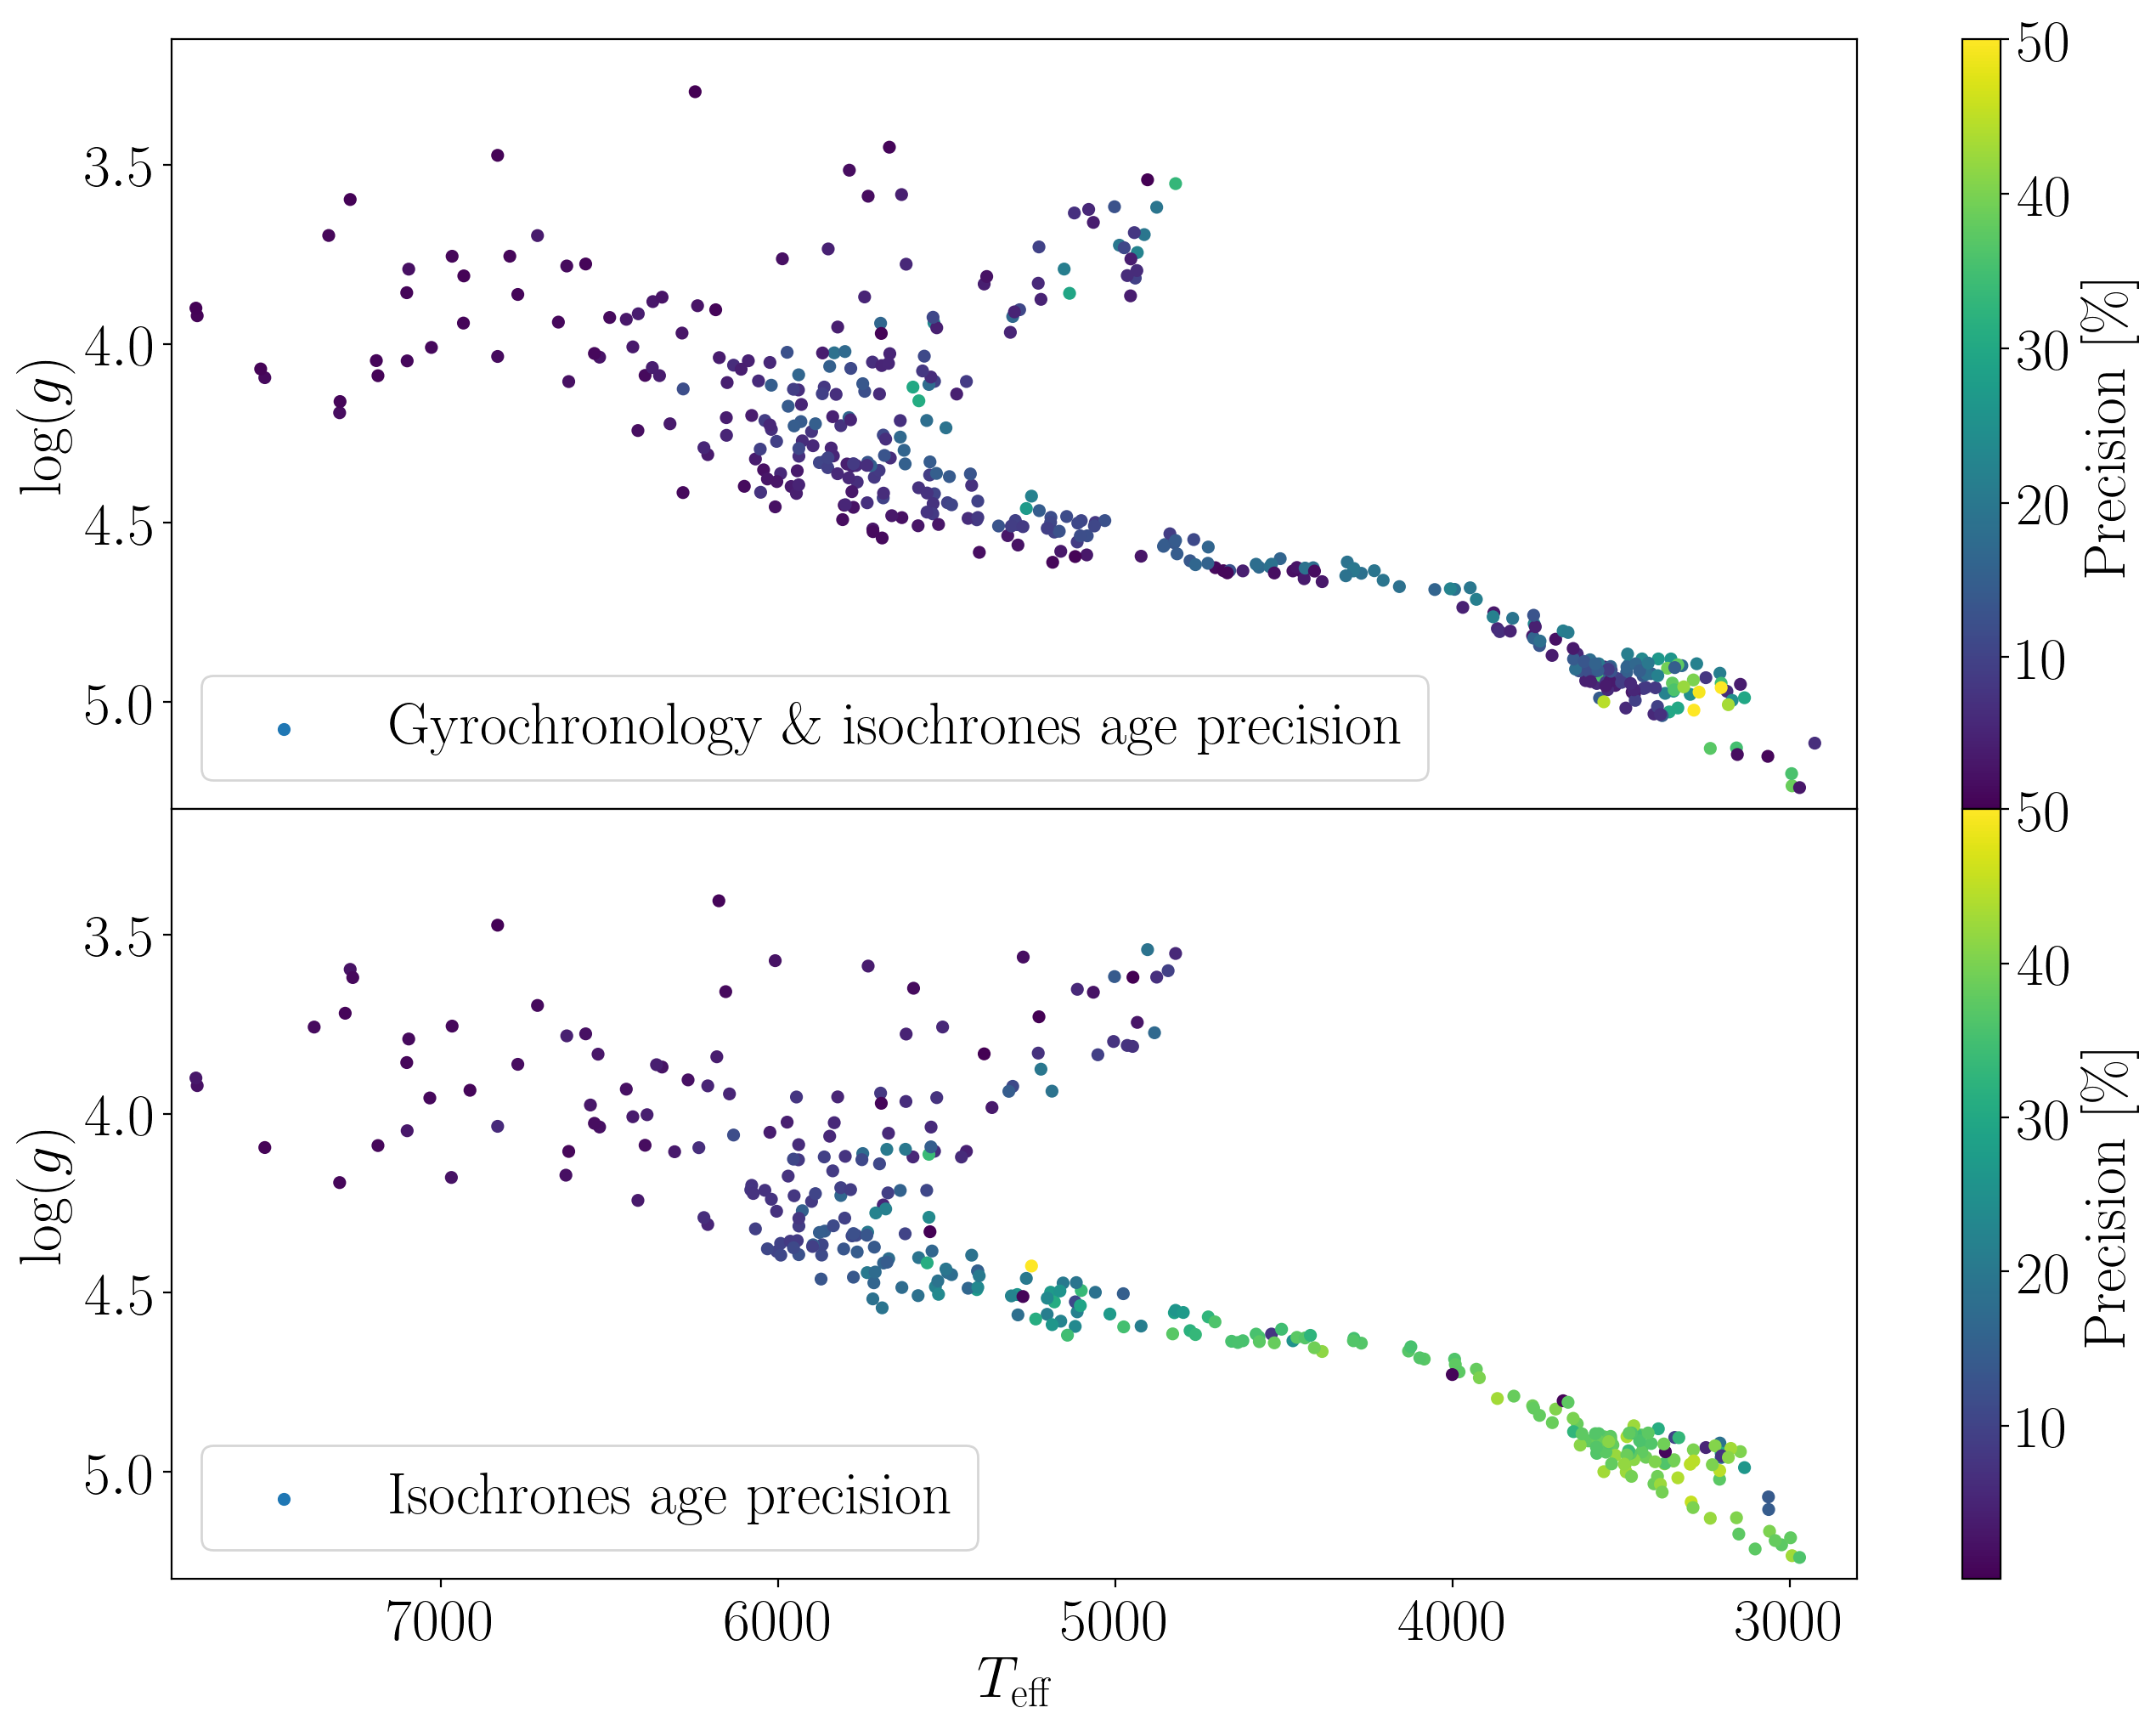

In [303]:
plotpar = {'legend.fontsize': 25}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 12), dpi=200)
plt.subplot(2, 1, 1)
plt.scatter(df.teff.values[inds], df.logg.values[inds], 
            label="$\mathrm{Gyrochronology~\&~isochrones~age~precision}$",
            c=(std/df.age.values[inds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.legend(loc="lower left")

plt.subplot(2, 1, 2)
plt.scatter(df.teff.values[iinds], df.logg.values[iinds], label="$\mathrm{Isochrones~age~precision}$",
            c=(istd/df.age.values[iinds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.subplots_adjust(hspace=0)
plt.legend(loc="lower left")

plt.savefig("../precision_plot.pdf")

In [430]:
def age_from_ml_and_med(meds, ml, color, c_thresh=1.3):
    age = np.ones(len(meds)) * np.nan
    cool_mask = color > c_thresh
    age[cool_mask] = meds[cool_mask]
    age[~cool_mask] = ml[~cool_mask]
    return age

age = age_from_ml_and_med(meds, ml, df.BP[inds] - df.RP[inds])
iage = age_from_ml_and_med(imeds, iml, df.BP[iinds] - df.RP[iinds])

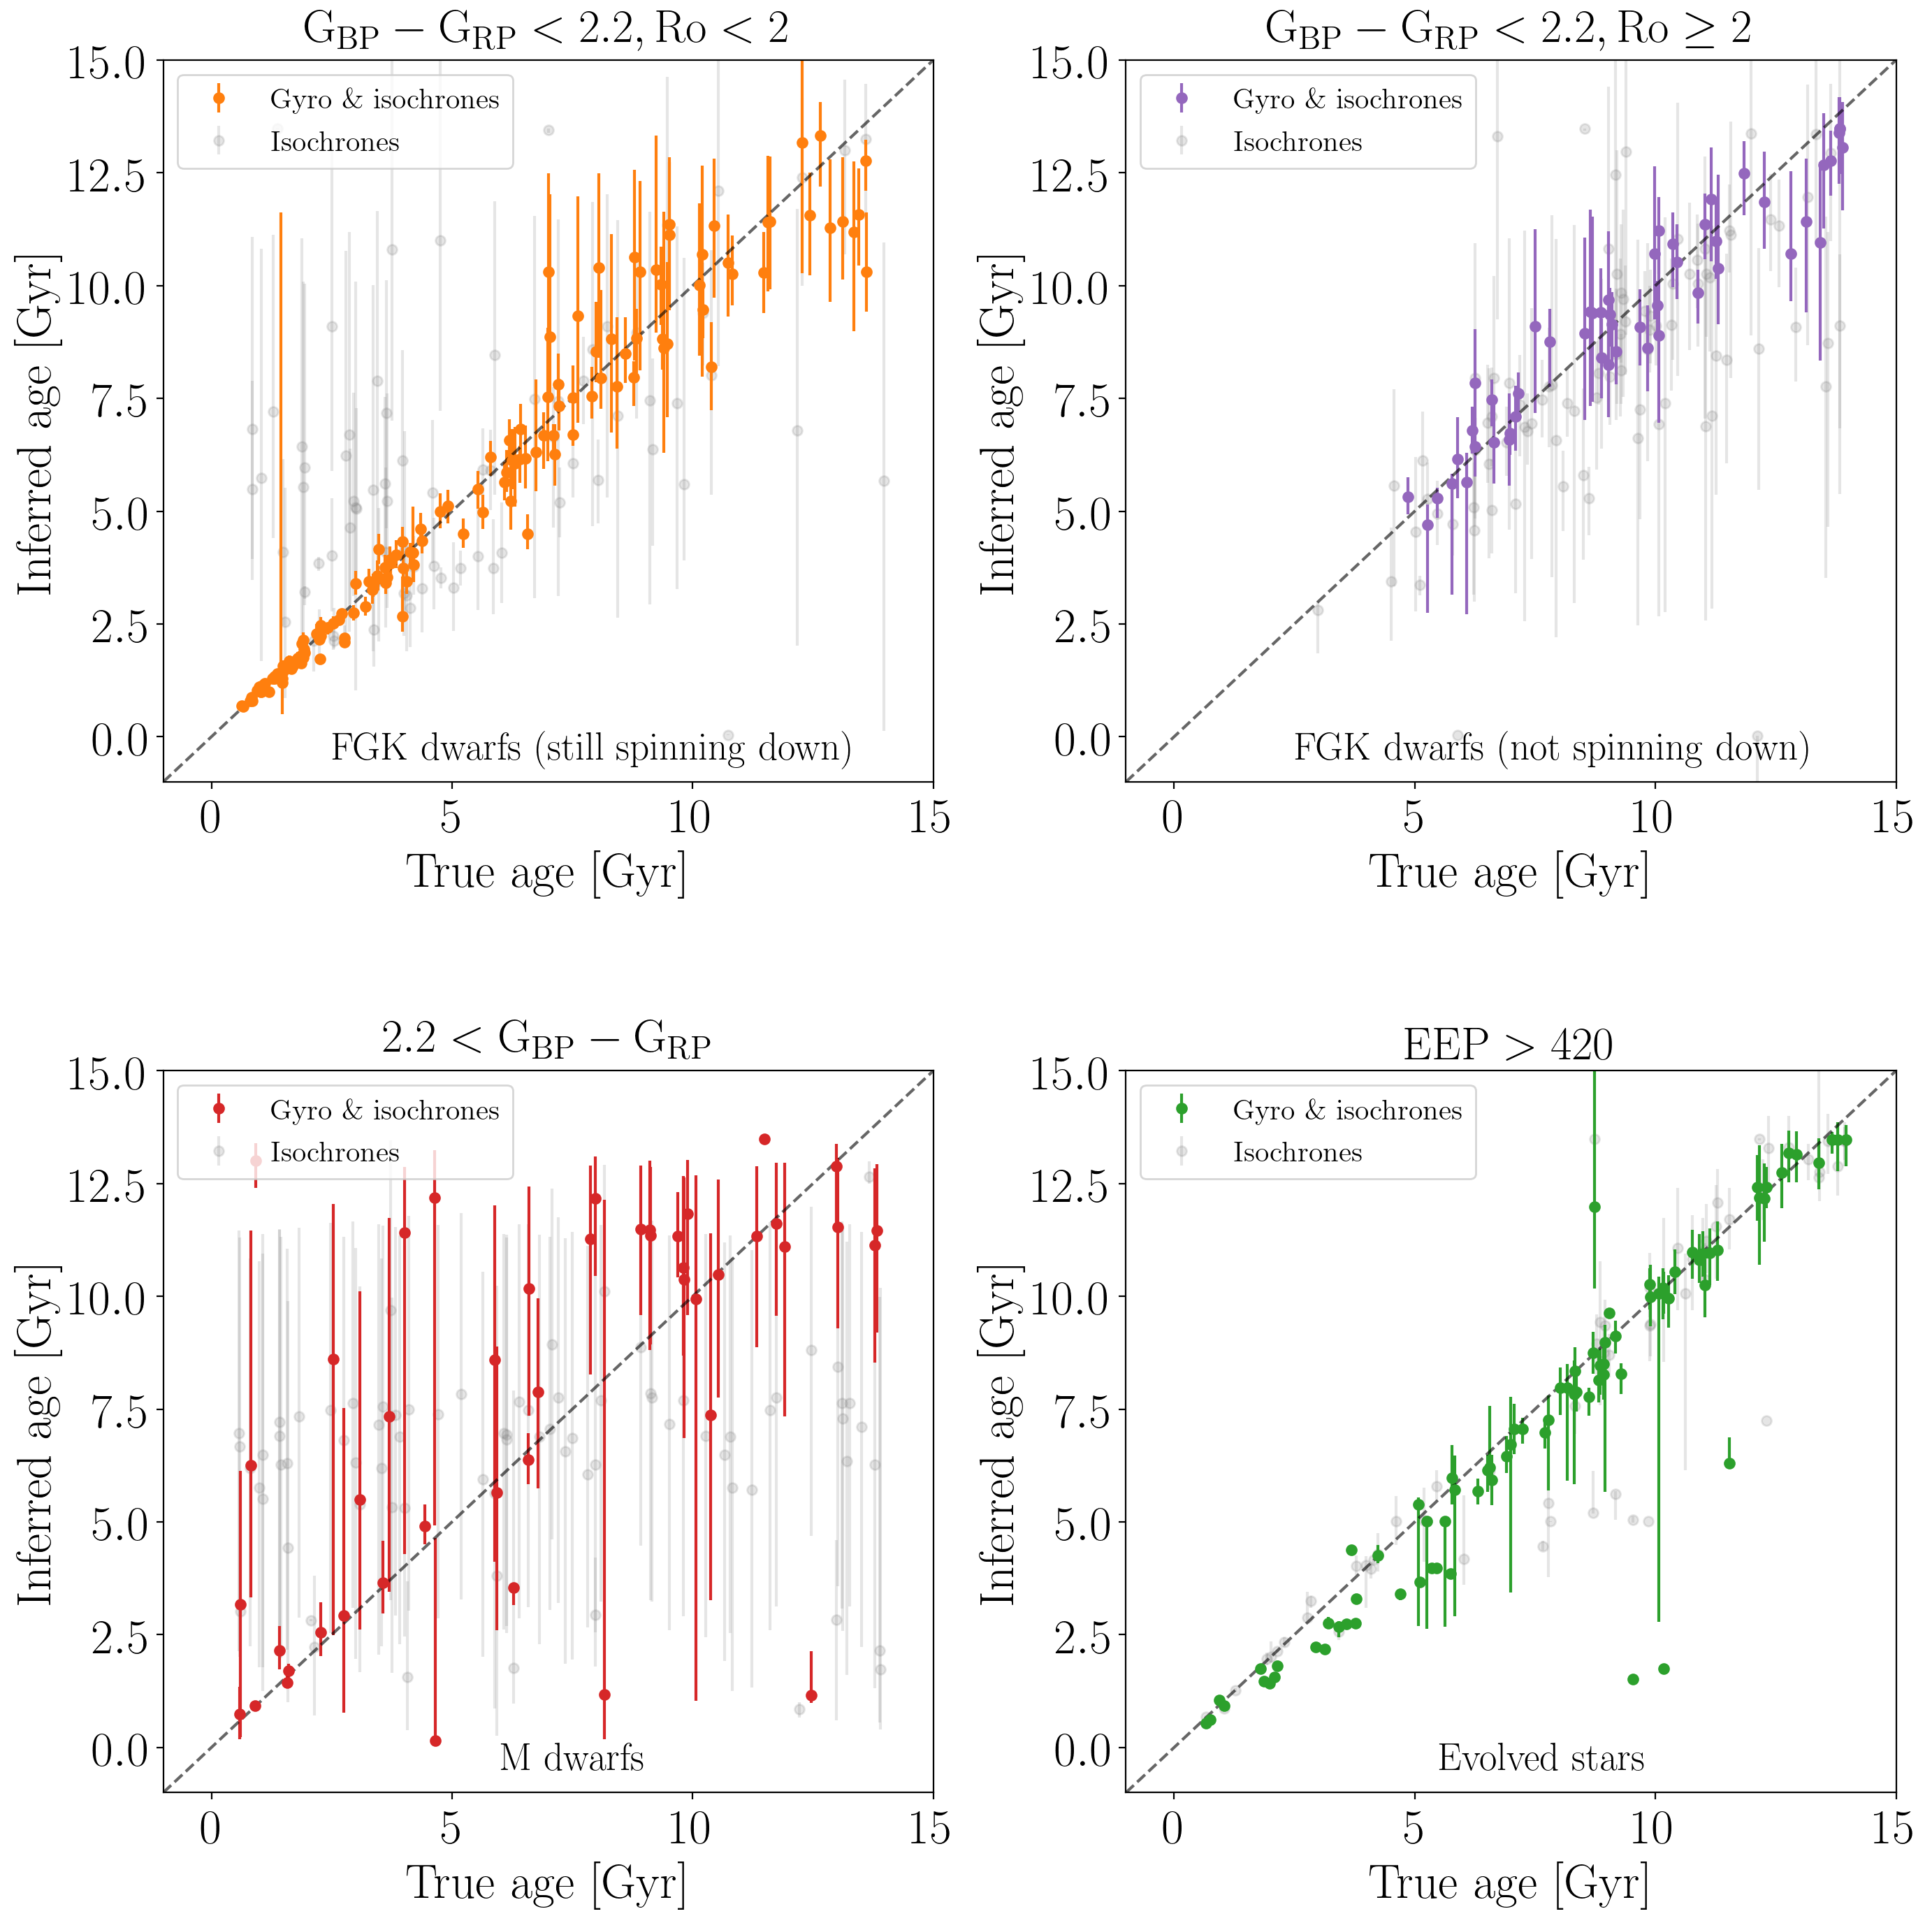

In [515]:
plotpar = {'legend.fontsize': 15,
           'font.size': 20}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 26), dpi=200)

plt.subplot(3, 2, 1)
plt.errorbar(true_age_gyr[inds][fgk], age[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$",
             rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], iage[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(-1, 16, 100)
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{G_{BP}-G_{RP} < 2.2, Ro < 2}$")
plt.legend(loc="upper left")
plt.text(2.5, -.5, "$\mathrm{FGK~dwarfs~(still~spinning~down)}$")

plt.subplot(3, 2, 2)
plt.errorbar(true_age_gyr[inds][rossbied], age[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True, color="tab:purple")
plt.errorbar(true_age_gyr[iinds][irossbied], iage[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{G_{BP}-G_{RP} < 2.2, Ro \geq 2}$")
plt.text(2.5, -.5, "$\mathrm{FGK~dwarfs~(not~spinning~down)}$")
plt.legend(loc="upper left")

# plt.subplot(3, 2, 3)
# plt.errorbar(true_age_gyr[inds][hot], age[hot], yerr=[errm[hot], errp[hot]], fmt=".",
#              color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True)
# plt.errorbar(true_age_gyr[iinds][ihot], iage[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
#              ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(-1, 15)
# plt.ylim(-1, 15)
# plt.title("$\mathrm{G_{BP} - G_{RP} < 0.56}$")
# plt.text(6, -.5, "$\mathrm{F~dwarfs}$")
# plt.legend(loc="upper left")

plt.subplot(3, 2, 3)
plt.errorbar(true_age_gyr[inds][cool], age[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][icool], iage[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{2.2 < G_{BP} - G_{RP}}$")
plt.text(6, -.5, "$\mathrm{M~dwarfs}$")
plt.legend(loc="upper left")

plt.subplot(3, 2, 4)
plt.errorbar(true_age_gyr[inds][evolved], age[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], iage[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{EEP > 420}$")
plt.text(5.5, -.5, "$\mathrm{Evolved~stars}$")
plt.legend(loc="upper left")

plt.subplots_adjust(wspace=.25, hspace=.4)
plt.savefig("../simulation_results.pdf")
plt.savefig("simulation_results")

1.7595224152517541
3.148166213238694


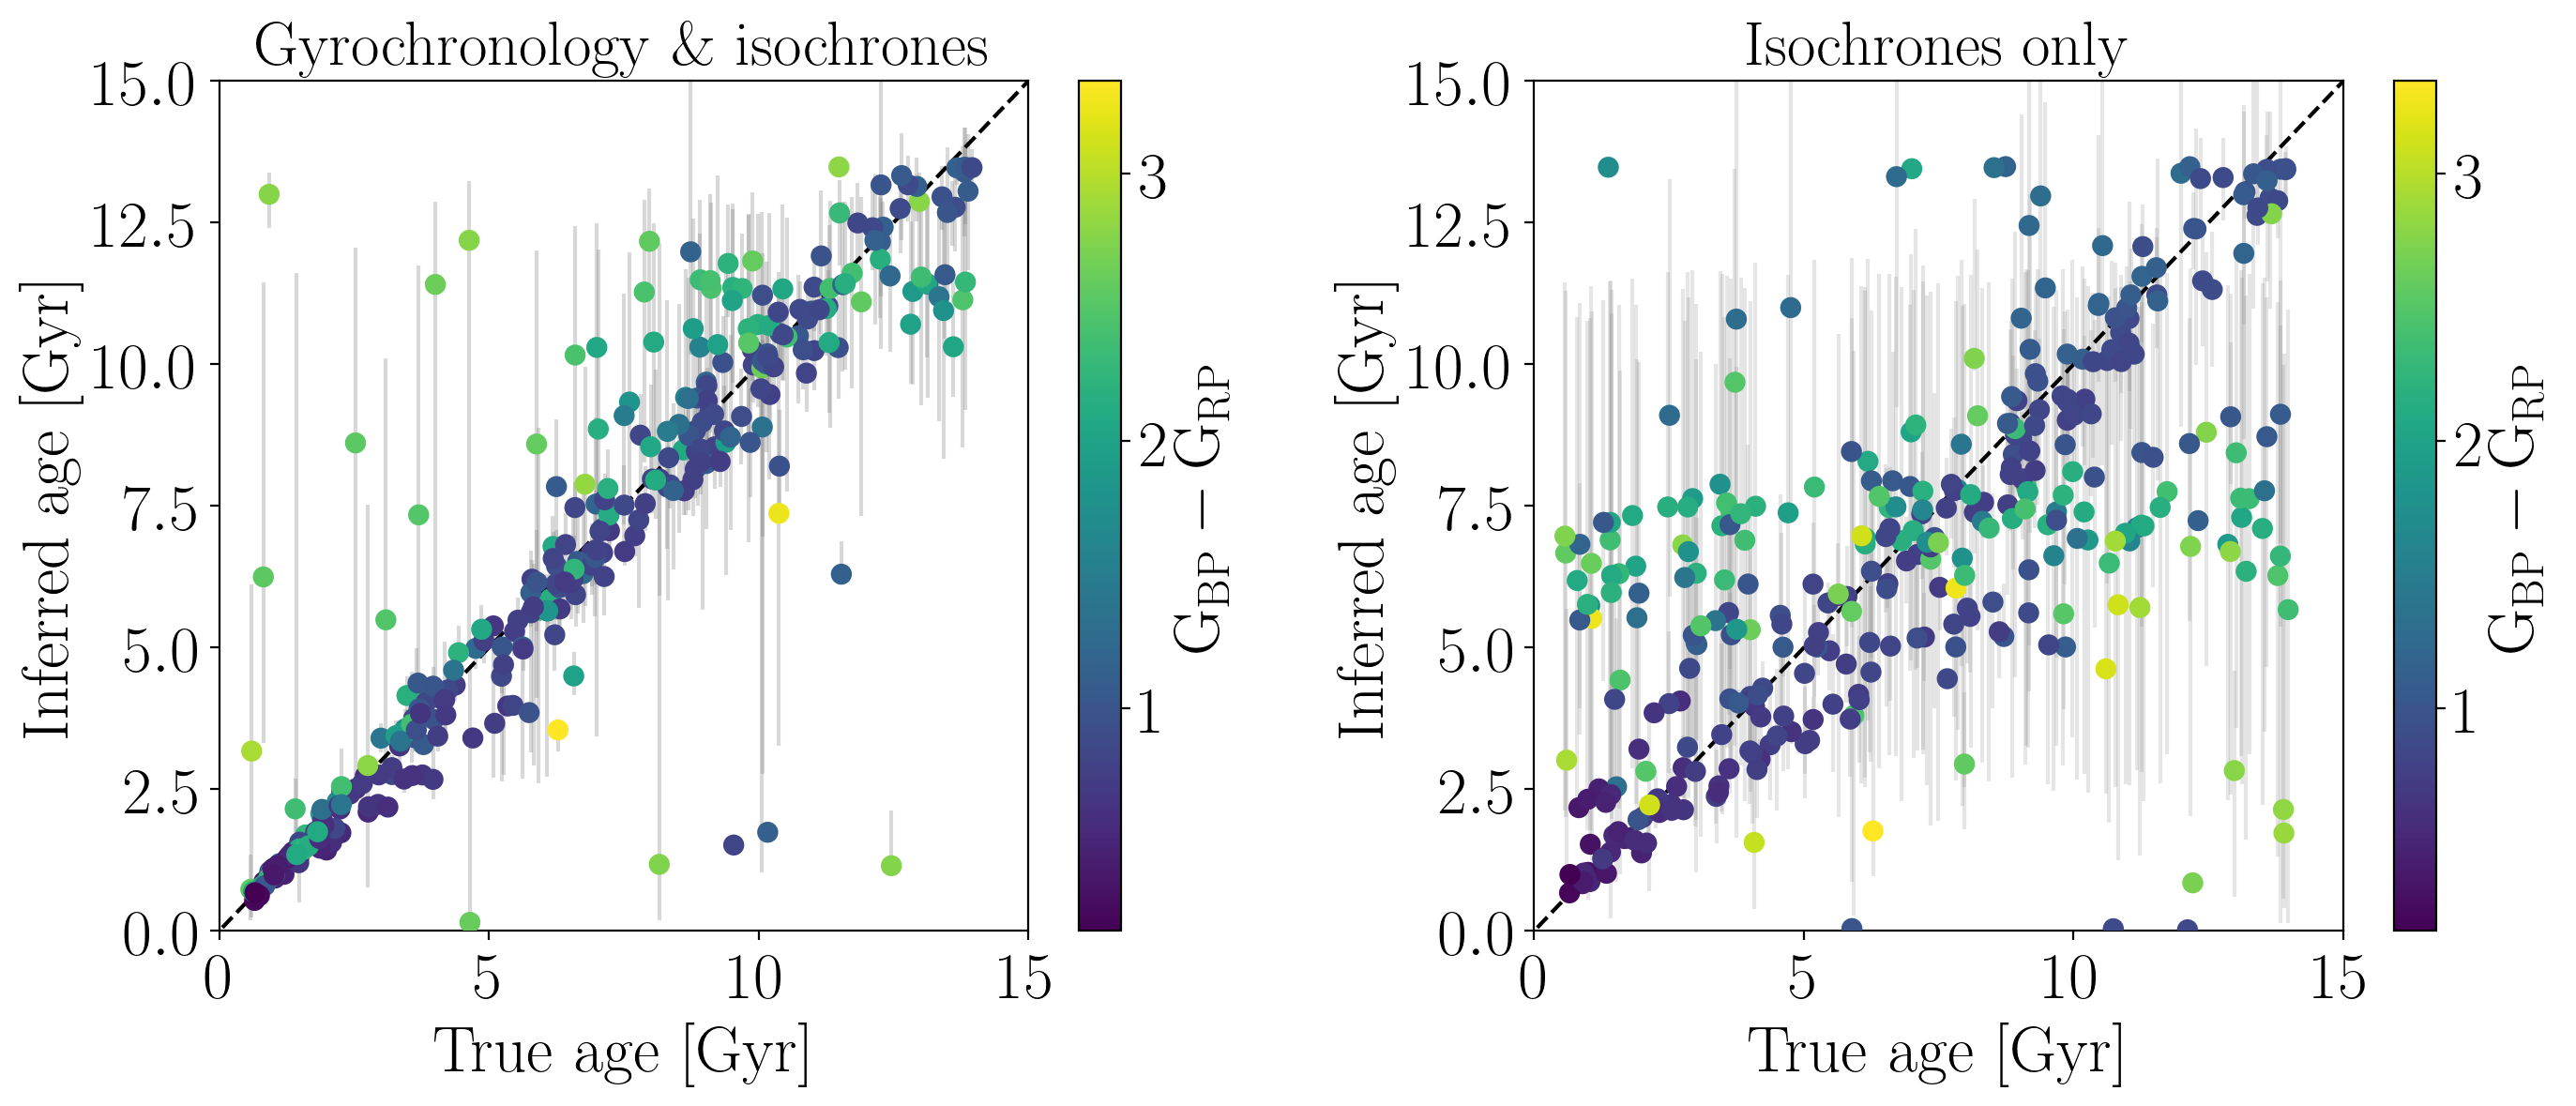

In [485]:
plotpar = {'legend.fontsize': 20}
plt.rcParams.update(plotpar)
plt.figure(figsize=(16, 6), dpi=200)

plt.subplot(1, 2, 1)
plt.scatter(true_age_gyr[inds], age, c=df.BP[inds] - df.RP[inds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[inds], age, yerr=[errm, errp], fmt=".", color=".5", alpha=.3, zorder=0,
            rasterized=True)
plt.colorbar(label="$\mathrm{G_{BP} - G_{RP}}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k--", zorder=0, rasterized=True)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Gyrochronology~\&~isochrones}$")

plt.subplot(1, 2, 2)
plt.scatter(true_age_gyr[iinds], iage, c=df.BP[iinds] - df.RP[iinds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[iinds], iage, yerr=[ierrm, ierrp], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.colorbar(label="$\mathrm{G_{BP} - G_{RP}}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Isochrones~only}$")

plt.subplots_adjust(wspace=.3, hspace=.4)
plt.savefig("../all_iso_gyro.pdf")

print(RMS(true_age_gyr[inds], age))
print(RMS(true_age_gyr[iinds], iage))

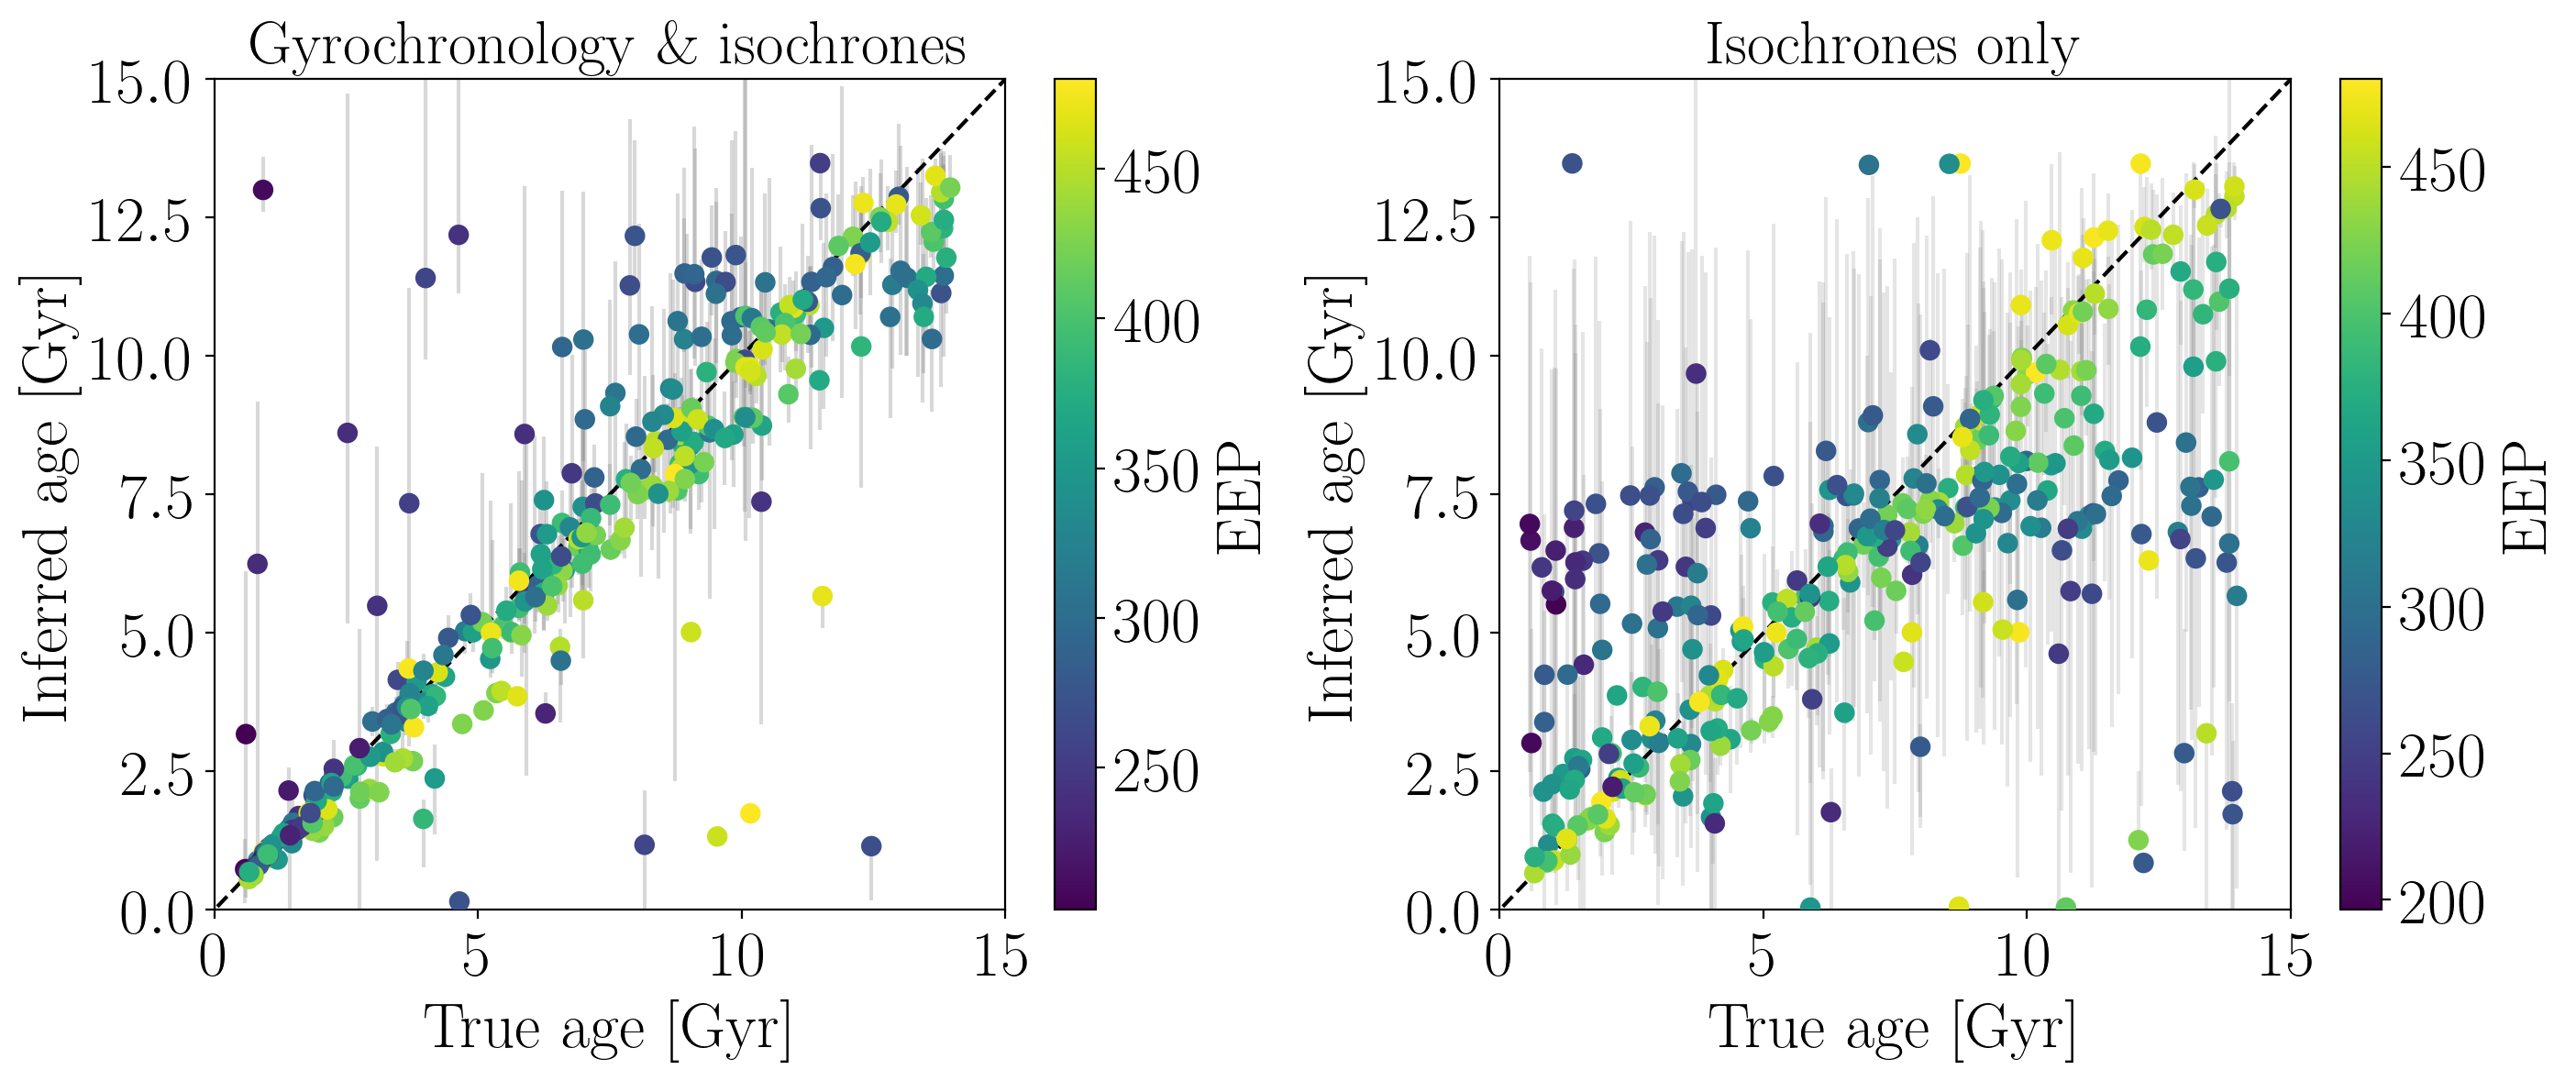

In [486]:
plt.figure(figsize=(16, 6), dpi=200)

plt.subplot(1, 2, 1)
plt.scatter(true_age_gyr[inds], meds, c=df.eep[inds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[inds], meds, yerr=[errp, errm], fmt=".", color=".5", alpha=.3, zorder=0,
            rasterized=True)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Gyrochronology~\&~isochrones}$")

plt.subplot(1, 2, 2)
plt.scatter(true_age_gyr[iinds], imeds, c=df.eep[iinds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[iinds], imeds, yerr=[ierrp, ierrm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Isochrones~only}$")

plt.subplots_adjust(wspace=.3, hspace=.4)

(347,) (347,) (347,)
36.649849503247026
22.734641092910035


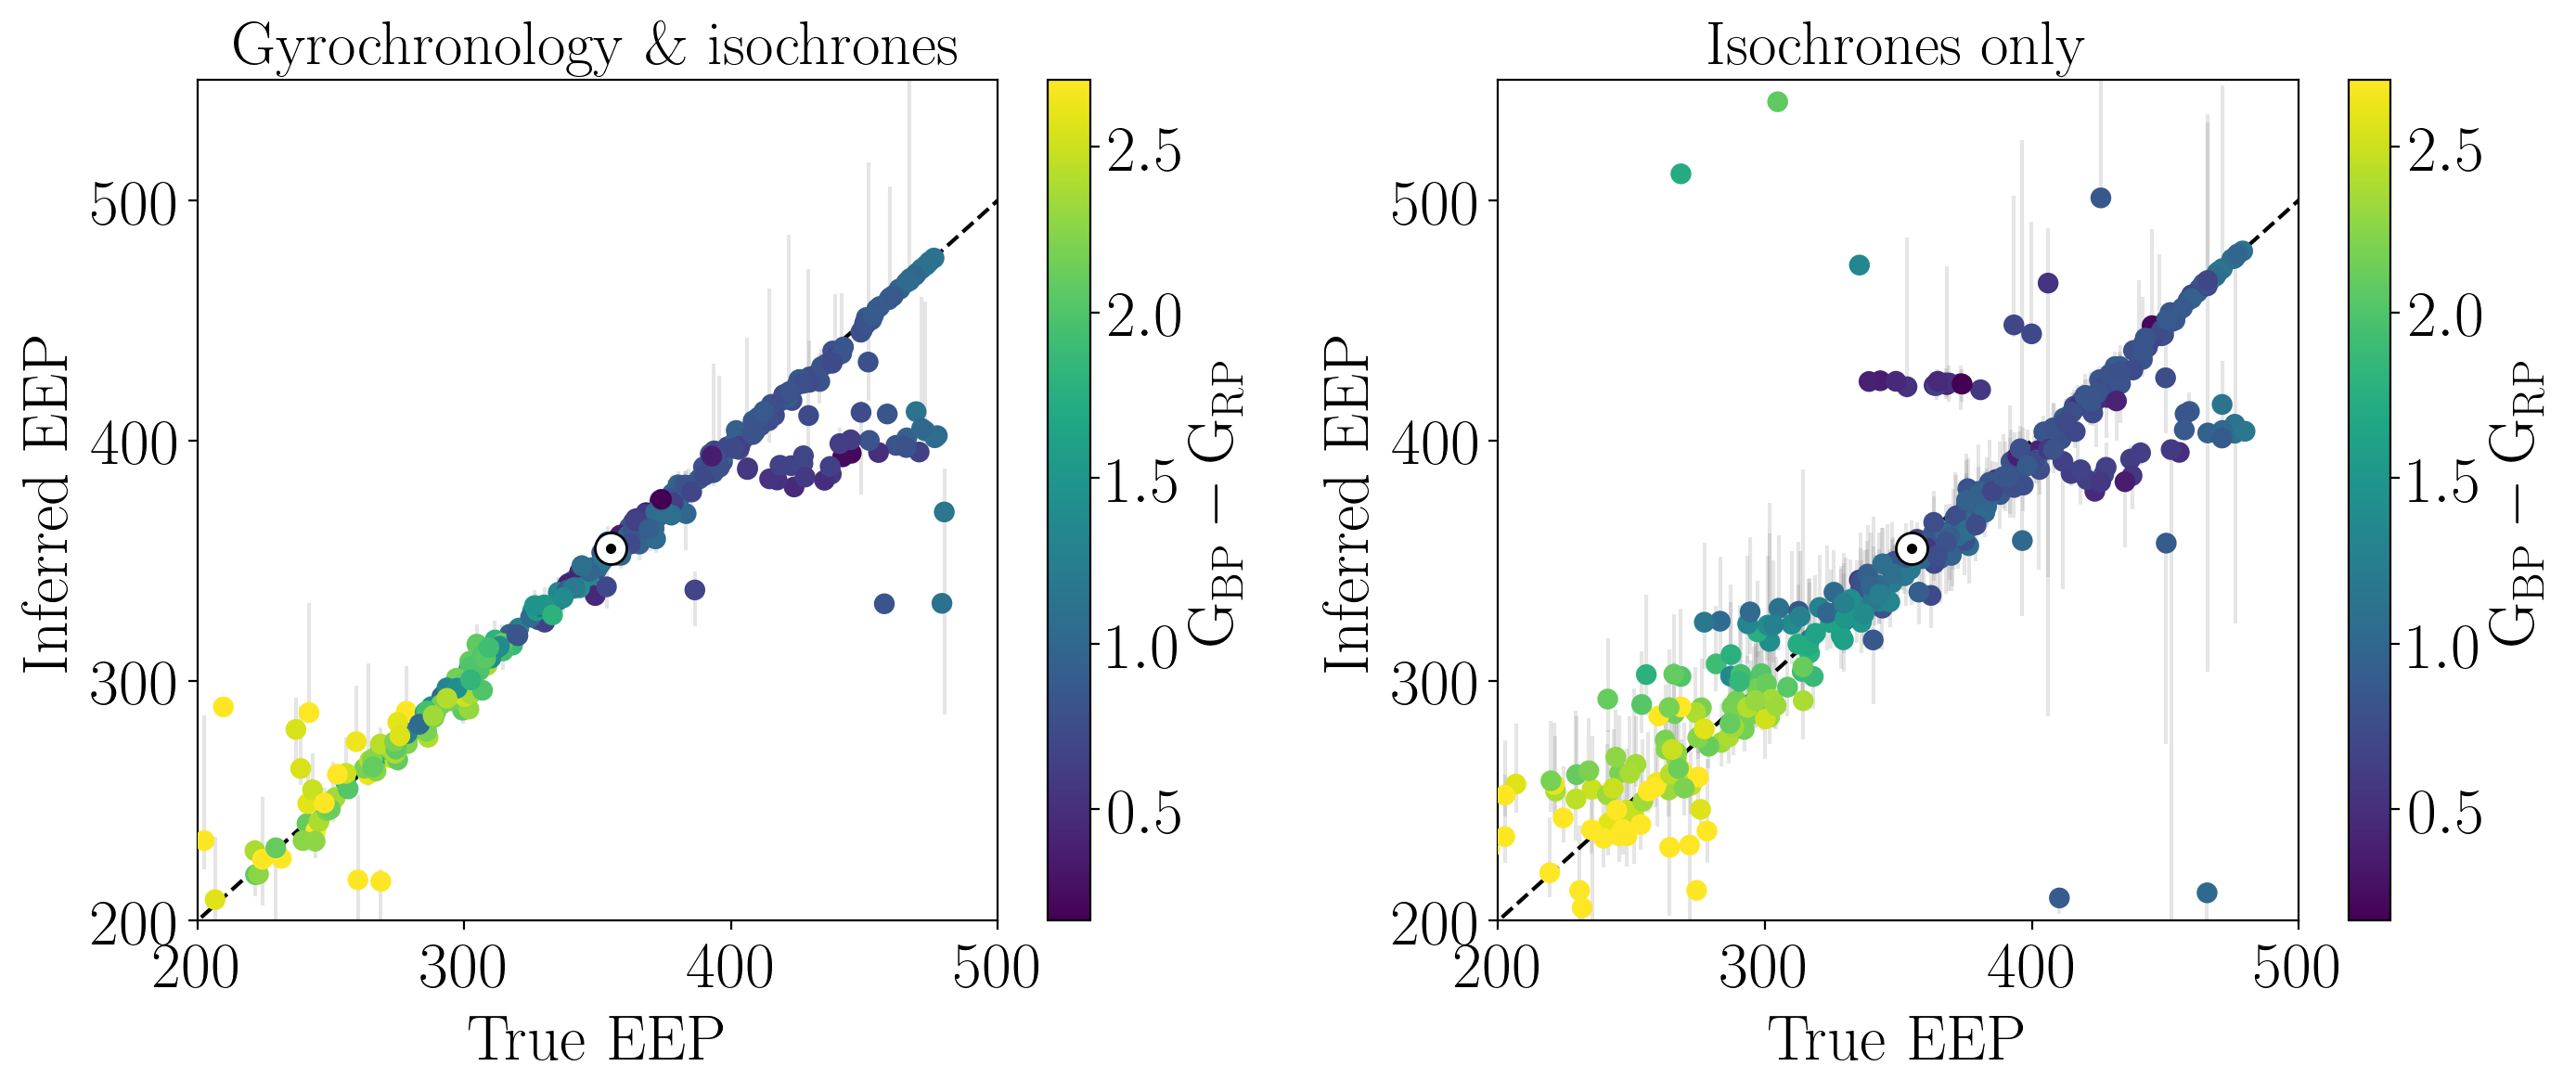

In [487]:
plt.figure(figsize=(16, 6), dpi=200)

xs = np.linspace(190, 500, 100)

plt.subplot(1, 2, 2)
print(np.shape(df.eep[iinds]), np.shape(ieeps), np.shape(df.BP[iinds]))
plt.scatter(df.eep[iinds], ieeps, c=df.BP[iinds] - df.RP[iinds],
             s=50, zorder=3, vmin=min(df.BP[iinds]-df.RP[iinds]), vmax=2.7, rasterized=True)
plt.errorbar(df.eep[iinds], ieeps, yerr=[ieep_errp, ieep_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(200, 500)
plt.ylim(200, 550)
plt.colorbar(label="$\mathrm{G_{BP}-G_{RP}}$")
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
plt.title("$\mathrm{Isochrones~only}$")

plt.scatter(355, 355, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(355, 355, "k.", zorder=3, rasterized=True)

# plt.plot(df.eep[iinds], ieeps, ".", color=".5", zorder=0)
plt.subplot(1, 2, 1)
plt.scatter(df.eep[inds], eeps, c=df.BP[inds] - df.RP[inds],
             s=50, zorder=3, vmin=min(df.BP[inds]-df.RP[inds]), vmax=2.7, rasterized=True)
plt.errorbar(df.eep[inds], eeps, yerr=[eep_errp, eep_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(200, 500)
plt.ylim(200, 550)
plt.colorbar(label="$\mathrm{G_{BP}- G_{RP}}$")
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
plt.title("$\mathrm{Gyrochronology~\&~isochrones}$")

plt.scatter(355, 355, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(355, 355, "k.", zorder=3, rasterized=True)

plt.subplots_adjust(wspace=.3)
plt.savefig("../eep.pdf")

print(RMS(ieeps, df.eep[iinds]))
print(RMS(eeps, df.eep[inds]))

0.11645441126502523
0.1045357759233754


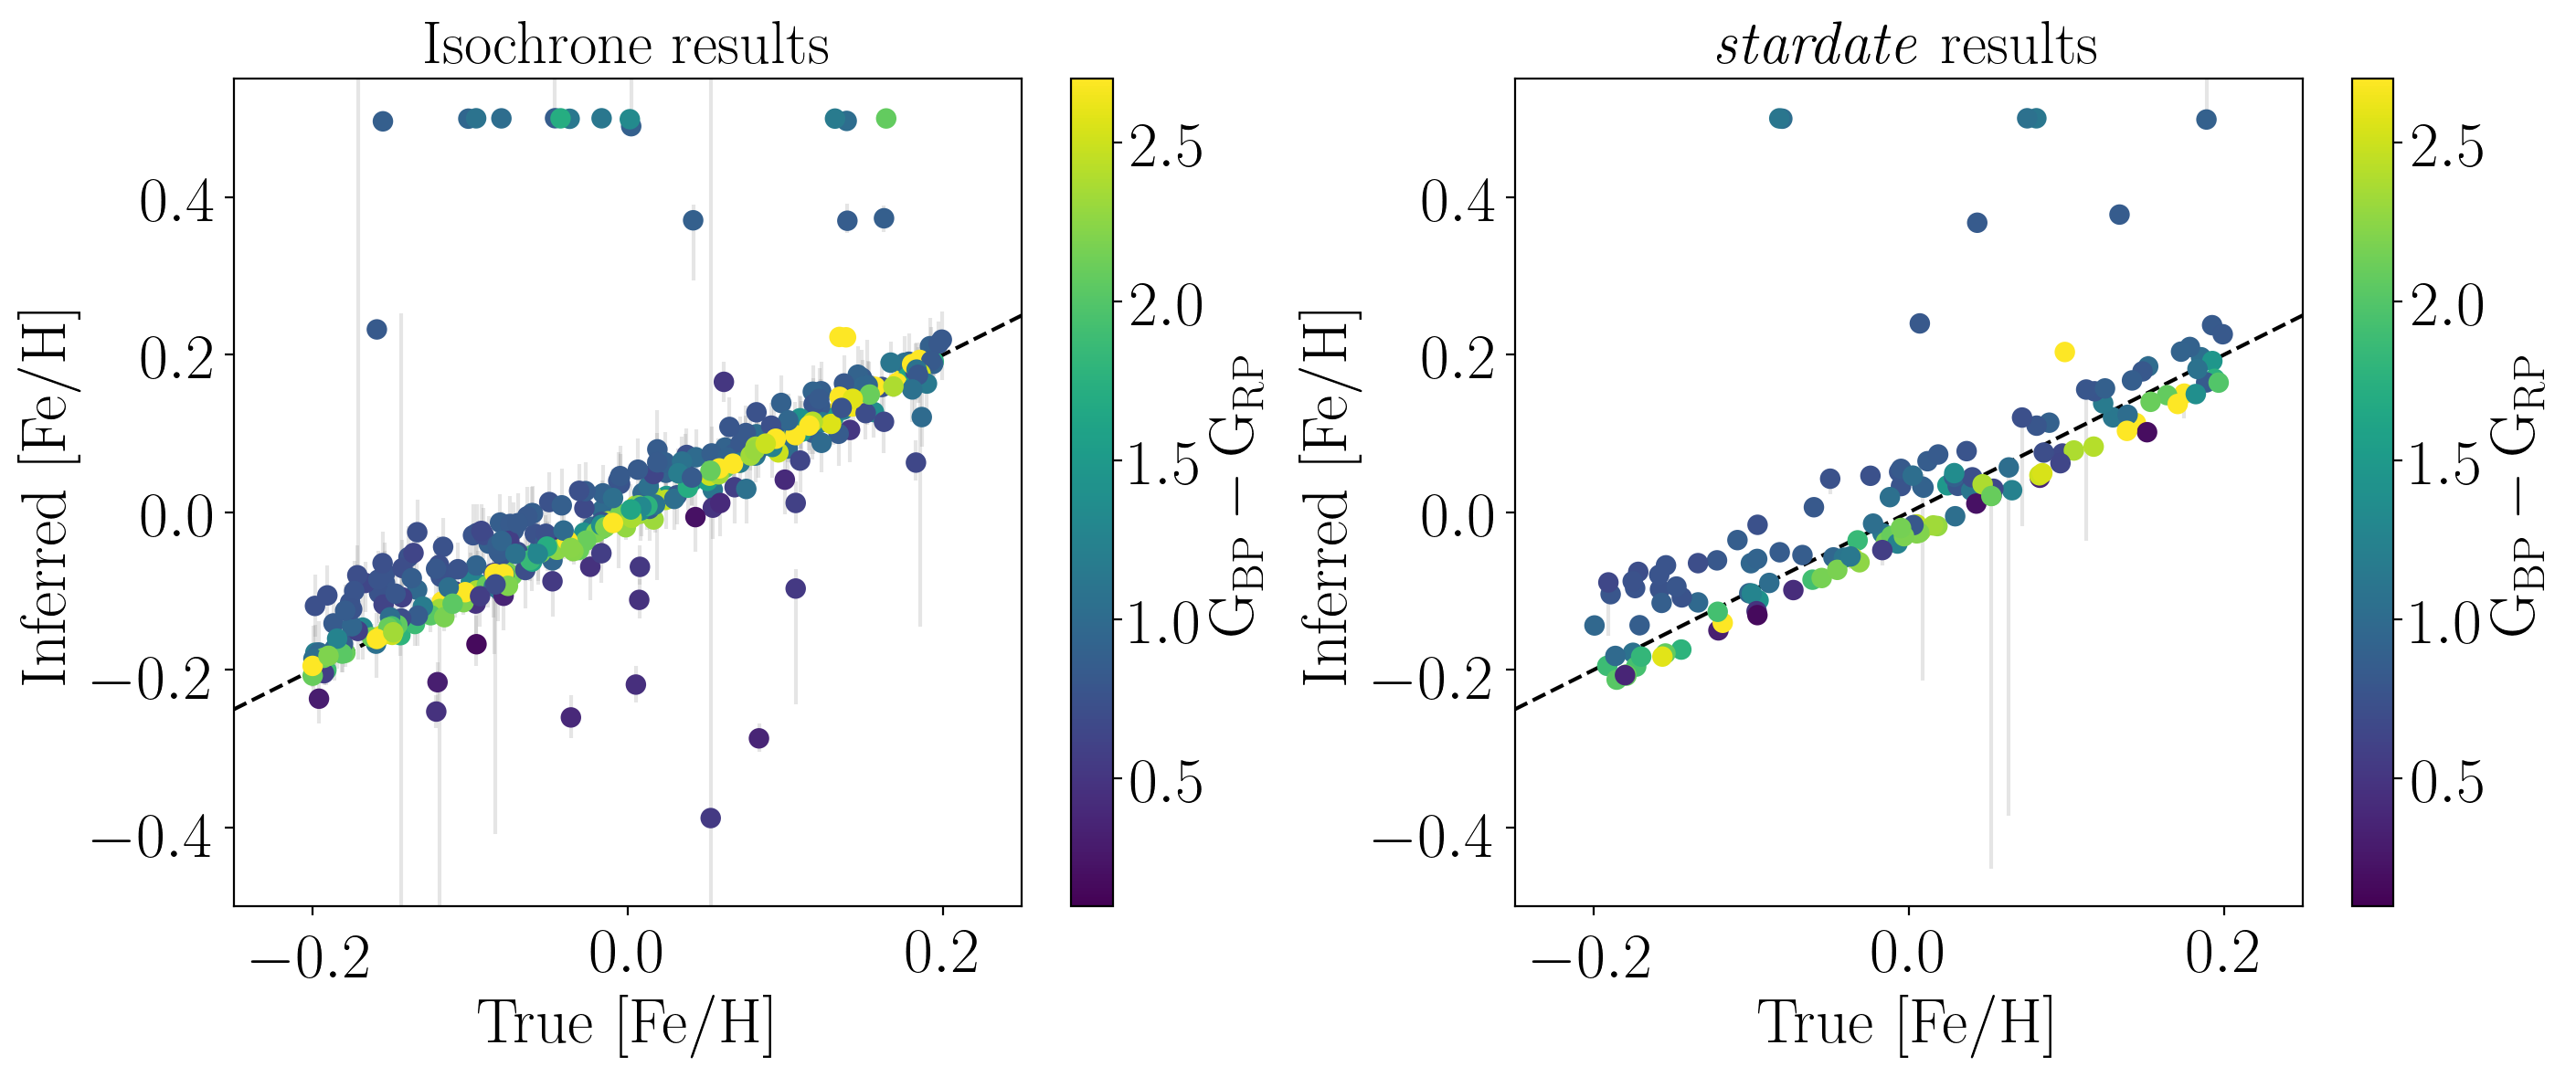

In [218]:
plt.figure(figsize=(16, 6), dpi=200)

xs = np.linspace(-.25, .25, 100)

plt.subplot(1, 2, 1)
plt.scatter(df.feh[iinds], ifehs, c=df.BP[iinds] - df.RP[iinds],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7, rasterized=True)
plt.errorbar(df.feh[iinds], ifehs, yerr=[ifeh_errp, ifeh_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(-.25, .25)
plt.ylim(-.5, .55)
plt.colorbar(label="$\mathrm{G_{BP}-G_{RP}}$")
plt.xlabel("$\mathrm{True~[Fe/H]}$")
plt.ylabel("$\mathrm{Inferred~[Fe/H]}$")
plt.title("$\mathrm{Isochrone~results}$")

# plt.plot(df.eep[iinds], ieeps, ".", color=".5", zorder=0)
plt.subplot(1, 2, 2)
plt.scatter(df.feh[inds], fehs, c=df.BP[inds] - df.RP[inds],
             s=50, zorder=3, vmin=min(df.BP-df.RP), vmax=2.7, rasterized=True)
plt.errorbar(df.feh[inds], fehs, yerr=[feh_errp, feh_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(-.25, .25)
plt.ylim(-.5, .55)
plt.colorbar(label="$\mathrm{G_{BP}- G_{RP}}$")
plt.xlabel("$\mathrm{True~[Fe/H]}$")
plt.ylabel("$\mathrm{Inferred~[Fe/H]}$")
plt.title("$\mathrm{{\it stardate}~results}$")

plt.subplots_adjust(wspace=.3)
plt.savefig("../feh.pdf")

print(RMS(ifehs, df.feh[iinds]))
print(RMS(fehs, df.feh[inds]))

In [488]:
def RMS(x, true):
    return np.sqrt(np.mean((x - true)**2))

print(np.std(meds - true_age_gyr[inds]))

print(RMS(meds, true_age_gyr[inds]), "Gyr")

1.8050342985025267
1.817905075343908 Gyr


Calculate precision for stardate.

In [499]:
def precision(stds, meds):
    return np.median(stds/meds)*100

def accuracy(true, meds):
    return np.median(abs(meds - true))*1e3

def rel_acc(true, meds):
    return np.median((abs(meds - true)/meds)*100)

print("median GK age precision = {:.2f} %".format(precision(std[fgk], age[fgk])))
print("GK RMS = {:.2f} Gyr".format(RMS(age[fgk], true_age_gyr[inds][fgk])))
print("median iso GK age precision = {:.2f} %".format(precision(istd[ifgk], iage[ifgk])))
print("GK iso RMS = {:.2f} Gyr".format(RMS(iage[ifgk], true_age_gyr[iinds][ifgk])))

print("\nmedian F age precision = {:.2f} %".format(precision(std[hot], age[hot])))
print("F RMS = {:.2f} Gyr".format(RMS(age[hot], true_age_gyr[inds][hot])))
print("median iso F age precision = {:.2f} %".format(precision(istd[ihot], iage[ihot])))
print("F iso RMS = {:.2f} Gyr".format(RMS(iage[ihot], true_age_gyr[iinds][ihot])))

print("\nmedian rossby age precision = {:.2f} %".format(precision(std[rossbied], age[rossbied])))
print("rossby RMS = {:.2f} Gyr".format(RMS(age[rossbied], true_age_gyr[inds][rossbied])))
print("median iso rossby age precision = {:.2f} %".format(precision(istd[irossbied], iage[irossbied])))
print("rossby iso RMS = {:.2f} Gyr".format(RMS(iage[irossbied], true_age_gyr[iinds][irossbied])))

print("\nmedian cool age precision = {:.2f} %".format(precision(std[cool], age[cool])))
print("cool RMS = {:.2f} Gyr".format(RMS(age[cool], true_age_gyr[inds][cool])))
print("median iso cool age precision = {:.2f} %".format(precision(istd[icool], iage[icool])))
print("cool iso RMS = {:.2f} Gyr".format(RMS(iage[icool], true_age_gyr[iinds][icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(std[evolved], age[evolved])))
print("evolved RMS = {:.2f} Gyr".format(RMS(age[evolved], true_age_gyr[inds][evolved])))
print("median iso subgiant age precision = {:.2f} %".format(precision(istd[ievolved], iage[ievolved])))
print("evolved iso RMS = {:.2f} Gyr".format(RMS(iage[ievolved], true_age_gyr[iinds][ievolved])))

print("\ntotal median age precision = {0}%".format(precision(std, age)))
print("total RMS = {:.2f} Gyr".format(RMS(age, true_age_gyr[inds])))
print("total iso median age precision = {0}%".format(precision(istd, iage)))
print("total iso RMS = {:.2f} Gyr".format(RMS(iage, true_age_gyr[iinds])))

median GK age precision = 10.82 %
GK RMS = 0.87 Gyr
median iso GK age precision = 32.06 %
GK iso RMS = 3.37 Gyr

median F age precision = 5.90 %
F RMS = 0.07 Gyr
median iso F age precision = 9.74 %
F iso RMS = 0.69 Gyr

median rossby age precision = 11.12 %
rossby RMS = 0.89 Gyr
median iso rossby age precision = 21.37 %
rossby iso RMS = 2.48 Gyr

median cool age precision = 25.45 %
cool RMS = 3.78 Gyr
median iso cool age precision = 55.89 %
cool iso RMS = 4.49 Gyr

median subgiant age precision = 10.90 %
evolved RMS = 1.40 Gyr
median iso subgiant age precision = 8.13 %
evolved iso RMS = 1.59 Gyr

total median age precision = 11.911047564887433%
total RMS = 1.76 Gyr
total iso median age precision = 28.73903089405328%
total iso RMS = 3.15 Gyr


Calculate precision for isochrone fitting.

In [225]:
print("median FGK age precision = {:.2f} %".format(precision(istd[ifgk], imeds[ifgk])))
print("FGK RMS = {:.2f} Gyr".format(RMS(imeds[ifgk], true_age_gyr[iinds][ifgk])))

print("\nmedian cool age precision = {:.2f} %".format(precision(istd[icool], imeds[icool])))
print("cool RMS = {:.2f} Gyr".format(RMS(imeds[icool], true_age_gyr[iinds][icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(istd[ievolved], imeds[ievolved])))
print("evolved RMS = {:.2f} Gyr".format(RMS(imeds[ievolved], true_age_gyr[iinds][ievolved])))

print("\ntotal median age precision = {0}%".format(precision(istd, imeds)))
print("total RMS = {:.2f} Gyr".format(RMS(imeds, true_age_gyr[iinds])))

median FGK age precision = 40.65 %
FGK RMS = 2.92 Gyr

median cool age precision = 55.89 %
cool RMS = 4.49 Gyr

median subgiant age precision = 8.06 %
evolved RMS = 2.35 Gyr

total median age precision = 28.380660165097854%
total RMS = 3.11 Gyr


Load Praesepe posteriors.

In [25]:
pr = pd.read_csv("data/praesepe.csv")
finite = np.isfinite(pr.bp.values - pr.rp.values) * np.isfinite(pr.G.values)
pr = pr.iloc[finite]

page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")
ipage_samps, ipmeds, iperrp, iperrm, ipstds, ipinds = read_files("praesepe_iso", pr.EPIC.values,
                                                           dirname="praesepe_results")

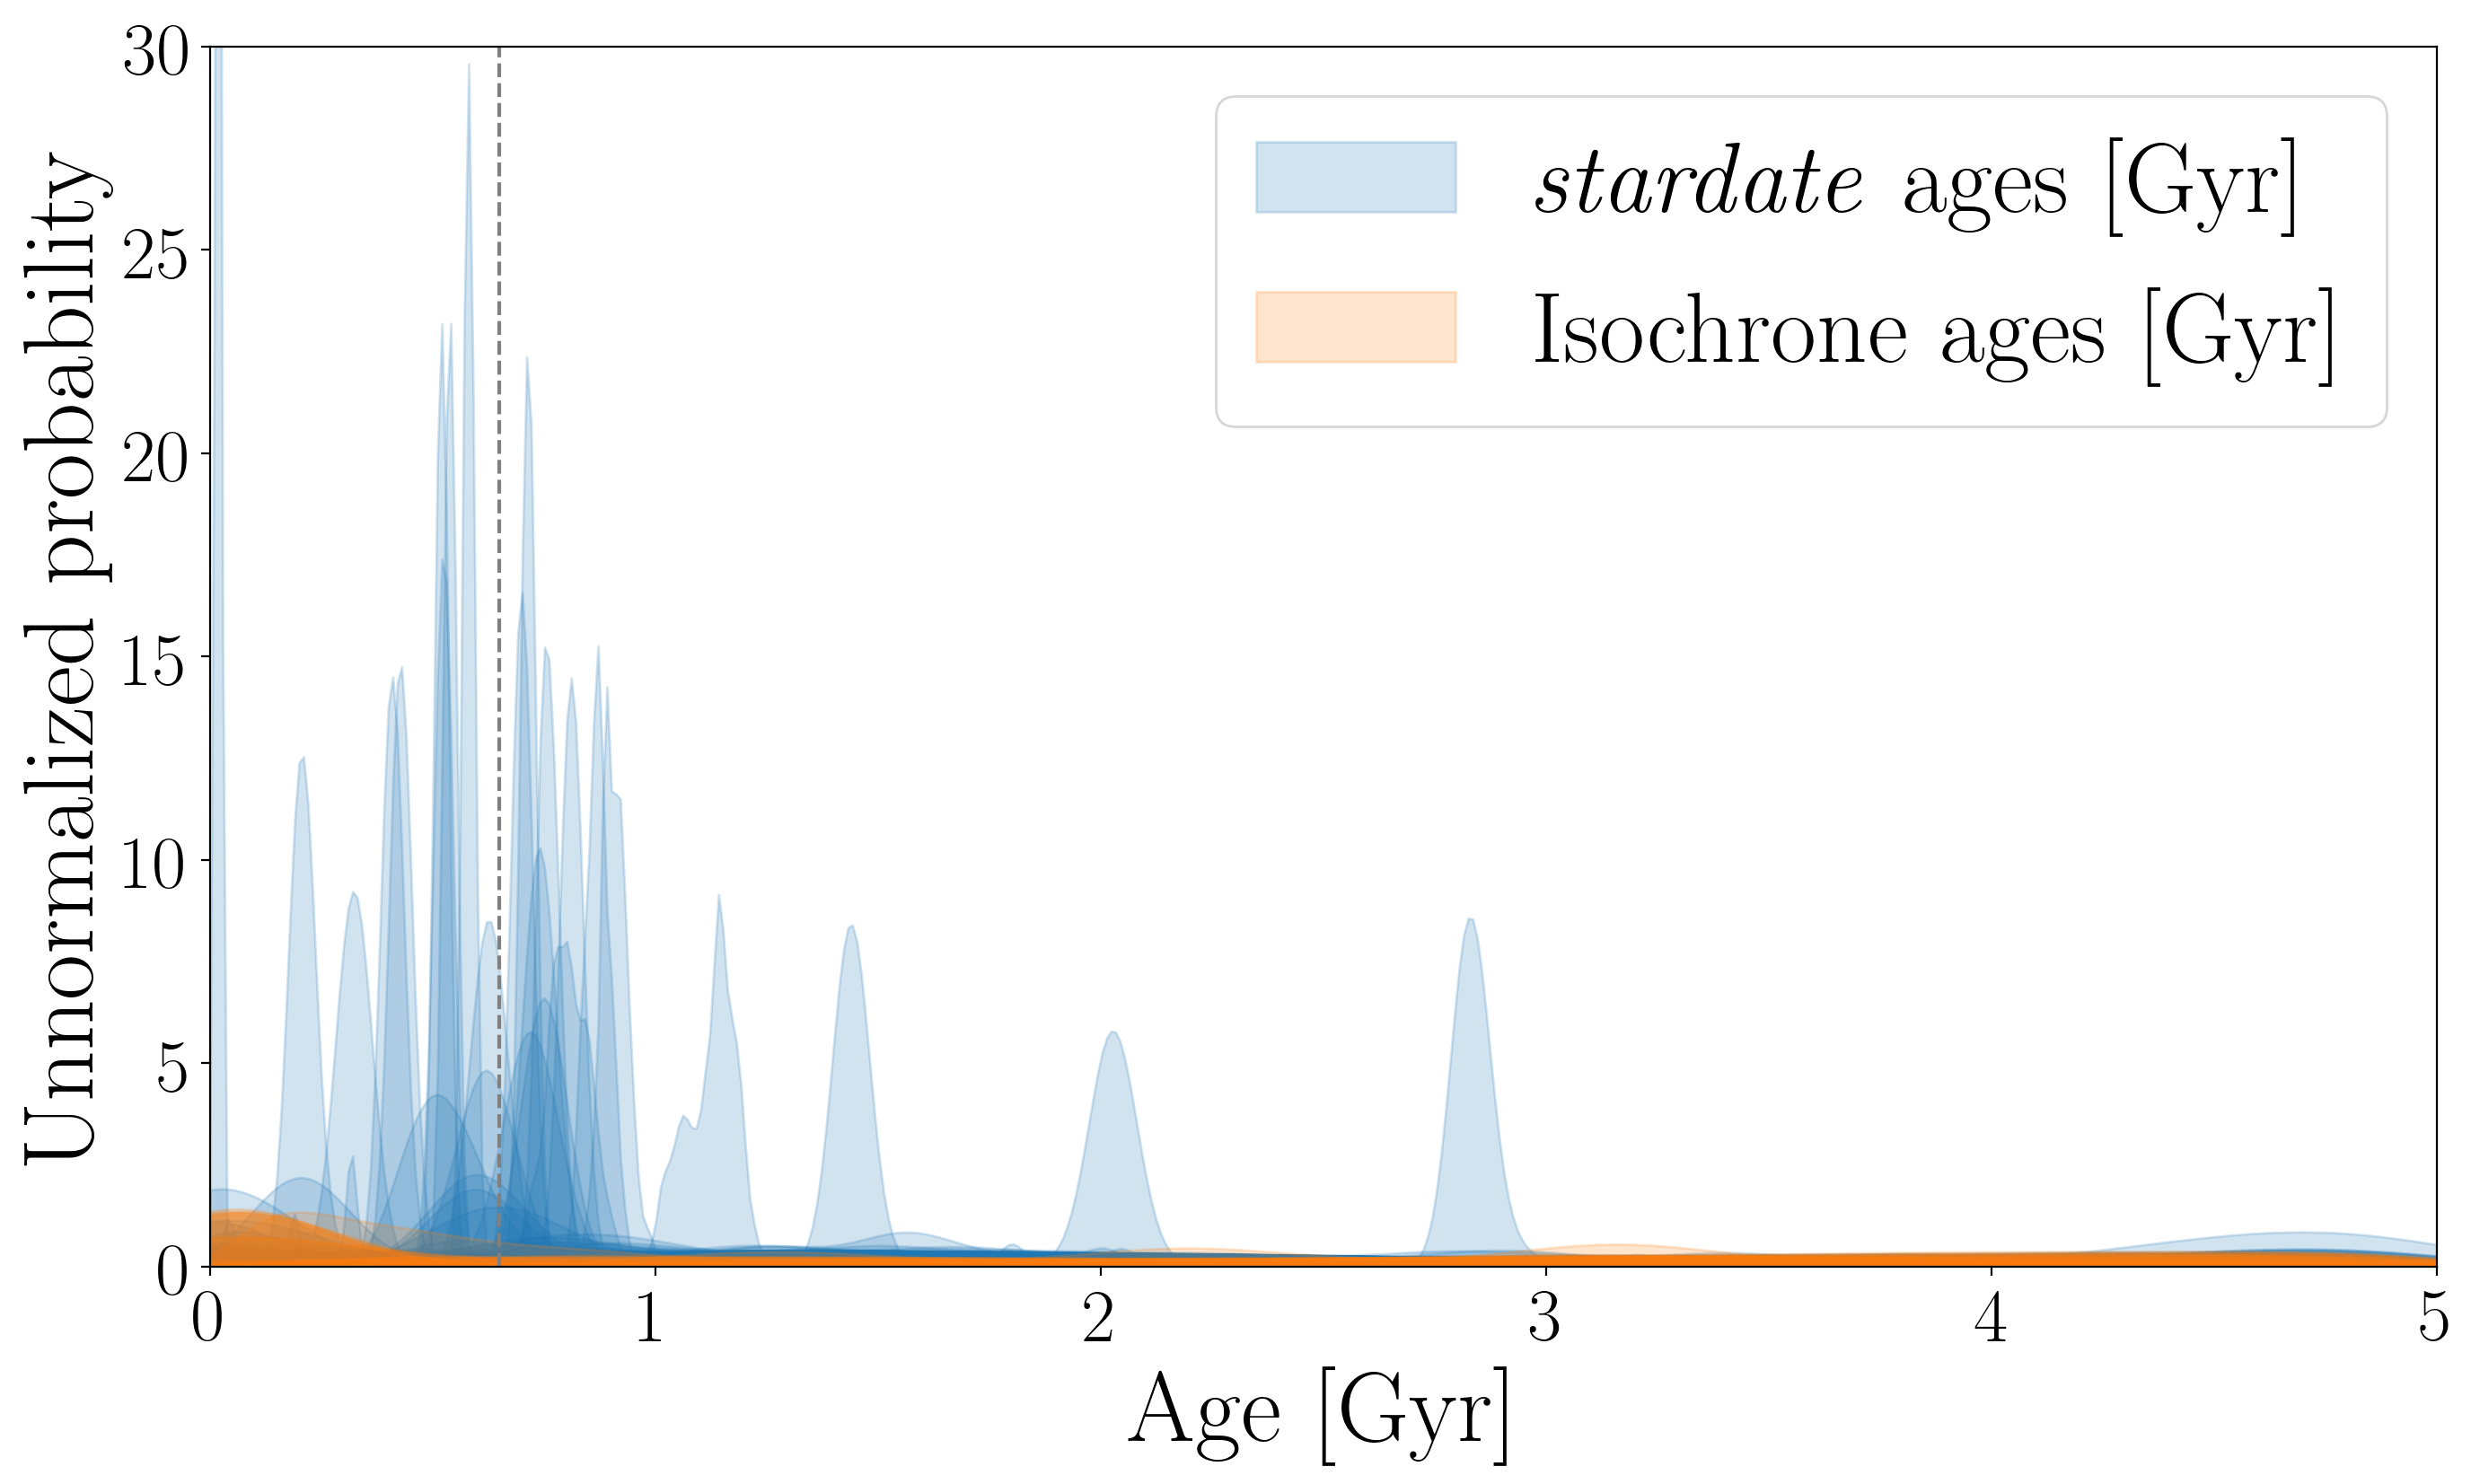

In [26]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 40,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import scipy.stats as sps

xs = np.linspace(0, 5, 500)

plt.figure(figsize=(16, 9), dpi=200) 

i = 0
mask = np.array(page_samps)[i] < 5
kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
                 rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")
# plt.hist(page_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(page_samps):
    mask = np.array(page_samps)[i] < 5
    kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
    plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
                     rasterized=True)
#     plt.hist(samps[mask], 50, alpha=.1, color="C0");
    
i = 0
mask = np.array(ipage_samps)[i] < 5
kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
                 rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
# plt.hist(ipage_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(ipage_samps):
    mask = np.array(ipage_samps)[i] < 5
    kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
    plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
                     rasterized=True)
#     plt.hist(samps[mask], 50, alpha=.1, color="C1");
    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

(15, 2)

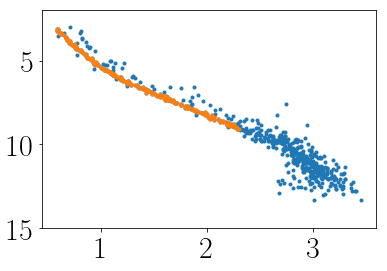

In [521]:
import scipy.optimize as spo

def abs_mag(G, D):
    return - 5*np.log10(D) + 5 + G

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(y - model(p, x))**2/yerr**2)

def clip(x, y, yerr):
    pinit = np.ones(5)
    results = spo.minimize(nll, pinit, args=(x, y, yerr))
    p = results.x

    inds = np.arange(len(x))
    for i in range(10):
        results = spo.minimize(nll, p, args=(x, y, yerr));
        p = results.x
        std = np.std(y - model(p, x))
        m = abs(y - model(p, x)) > 3*std
        x, y, yerr = x[~m], y[~m], yerr[~m]
        inds = inds[~m]
    return x, y, yerr, p, inds

cool = pr.bp.values - pr.rp.values < 2.3

abs_G = abs_mag(pr.G.values, (1./pr.parallax.values)*1e3)
_x, _y, _yerr, _p, _inds = clip(pr.bp.values[cool]-pr.rp.values[cool],
                                abs_G[cool], np.ones(len(abs_G[cool]))*.001)

binary_flag = np.zeros(len(pr.G.values[cool]), dtype=bool)
binary_flag[_inds] = np.ones(len(binary_flag[_inds]), dtype=bool)

plt.plot(pr.bp.values-pr.rp.values, abs_G, ".")
plt.plot(_x, _y, ".")
plt.ylim(15, 2)

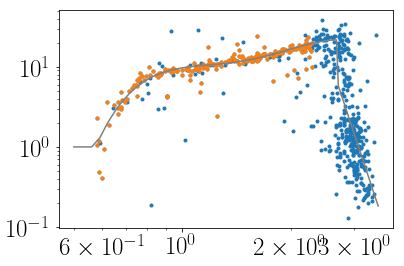

In [408]:
from stardate.lhf import gyro_model_praesepe

plt.plot(bprp.values, pr.prot.values, ".")
plt.plot(bprp.values[fm][m][_inds], pr.prot.values[fm][m][_inds], ".")
xs = np.linspace(.5, 3.5, 100)
ps = np.zeros(len(xs))
for i, x in enumerate(xs):
    ps[i] = gyro_model_praesepe(np.log10(650*1e6), x)
plt.loglog(xs, 10**ps, color=".5")
plt.yscale("log")

In [414]:
page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")
print(len(pmeds), "stars")

204 stars


In [415]:
piage_samps, pimeds, pierrp, pierrm, pistds, piinds = read_files("praesepe_iso", pr.EPIC.values,
                                                                 dirname="praesepe_results");
print(len(pimeds), "stars")

23 stars


In [416]:
pgage_samps, pgmeds, pgerrp, pgerrm, pgstds, pginds = read_files("praesepe_gyro", pr.EPIC.values,
                                                                 dirname="praesepe_results")
print(len(pgmeds), "stars")

146 stars


In [418]:
def find_single_measured_inds(pr, measured_inds, meds, errp, errm, std, single_epics):
    epics_measured = pr.iloc[measured_inds]
    epics_measured["age"] = np.array(meds)
    epics_measured["age_errp"] = np.array(errp)
    epics_measured["age_errm"] = np.array(errm)
    epics_measured["age_err"] = np.array(std)
    epics_measured["i"] = np.arange(len(meds))
    final_df = pd.merge(epics_measured, single_epics, on="EPIC", how="inner").drop_duplicates()
    return final_df
    
single_epics = pd.DataFrame(dict({"EPIC": pr.EPIC.values[fm][m][_inds]}))
pdf = find_single_measured_inds(pr, pinds, pmeds, perrp, perrm, pstds, single_epics)
idf = find_single_measured_inds(pr, piinds, pimeds, pierrp, pierrm, pistds, single_epics)
gdf = find_single_measured_inds(pr, pginds, pgmeds, pgerrp, pgerrm, pgstds, single_epics)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

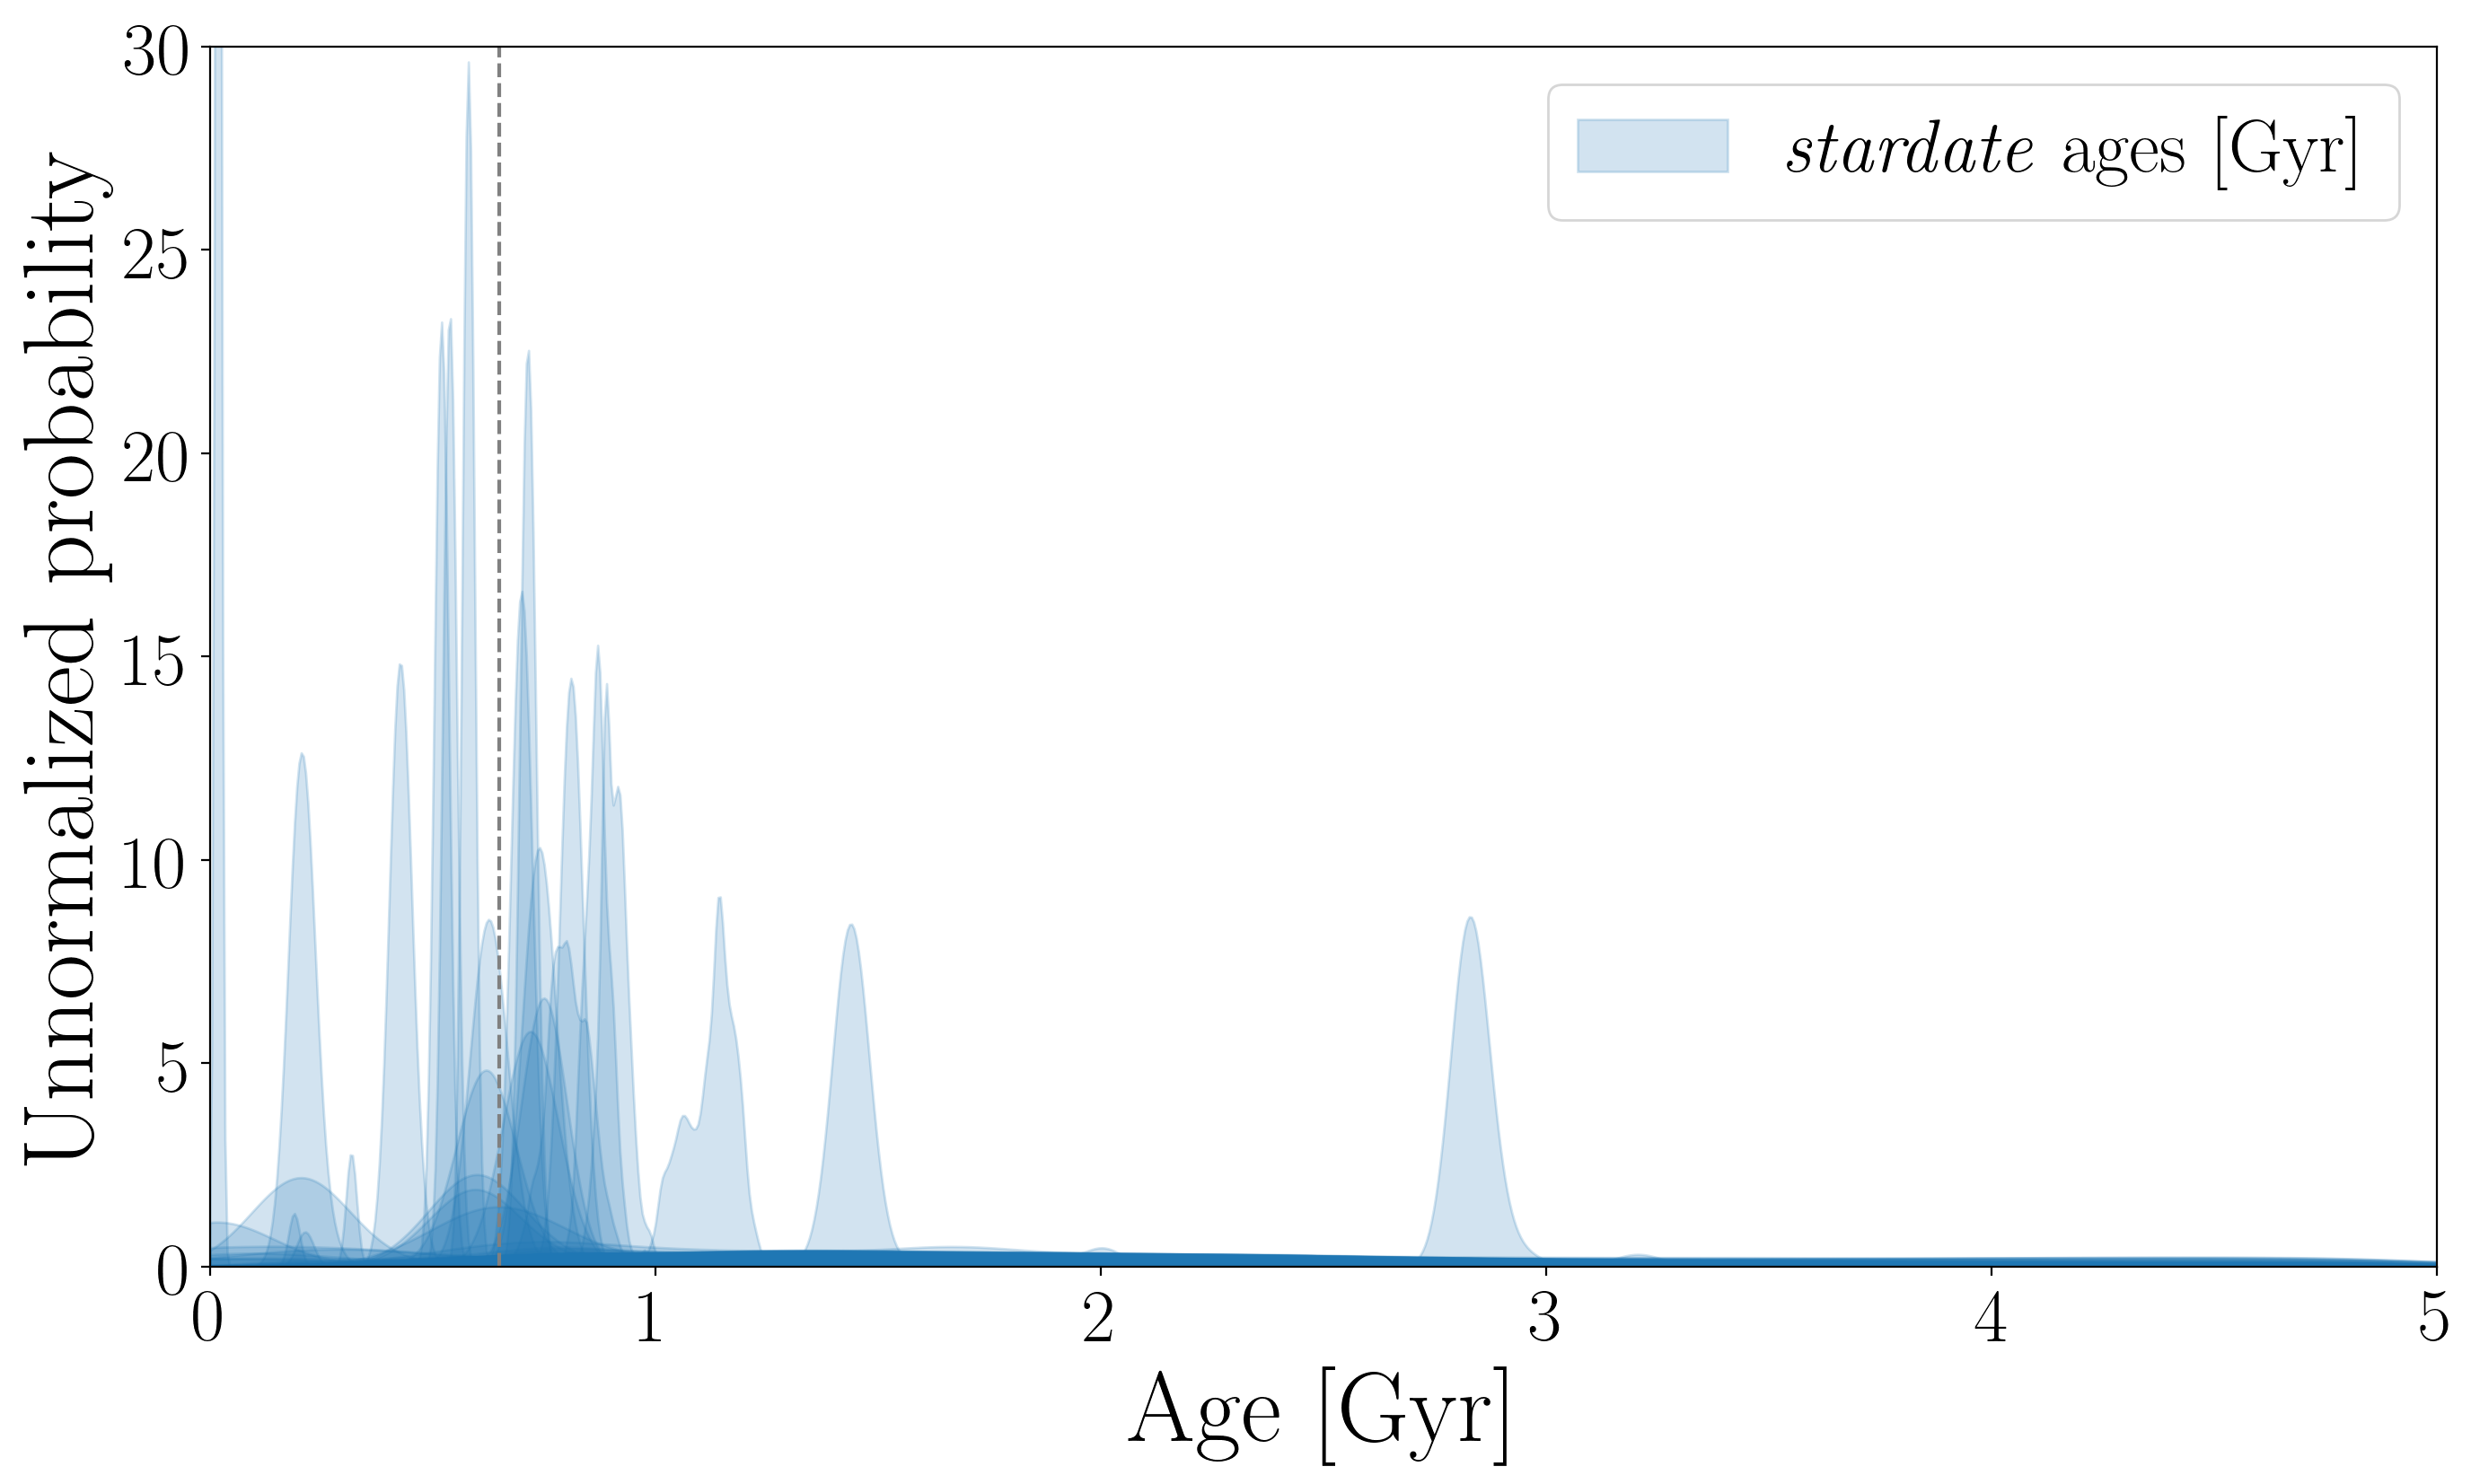

In [458]:
import scipy.stats as sps

xs = np.linspace(0, 5, 1000)

plt.figure(figsize=(16, 9), dpi=200)
    
# for i in gdf.i.values:
#     mask = np.array(pgage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(pgage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C2", alpha=.1, zorder=0)    

# i = pdf.i.values[0]
# mask = np.array(page_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")

# for i in pdf.i.values[1:]:
#     mask = np.array(page_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True)

# i = idf.i.values[0]
# mask = np.array(piage_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
    
# for i in idf.i.values[1:]:
#     mask = np.array(piage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True)
    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

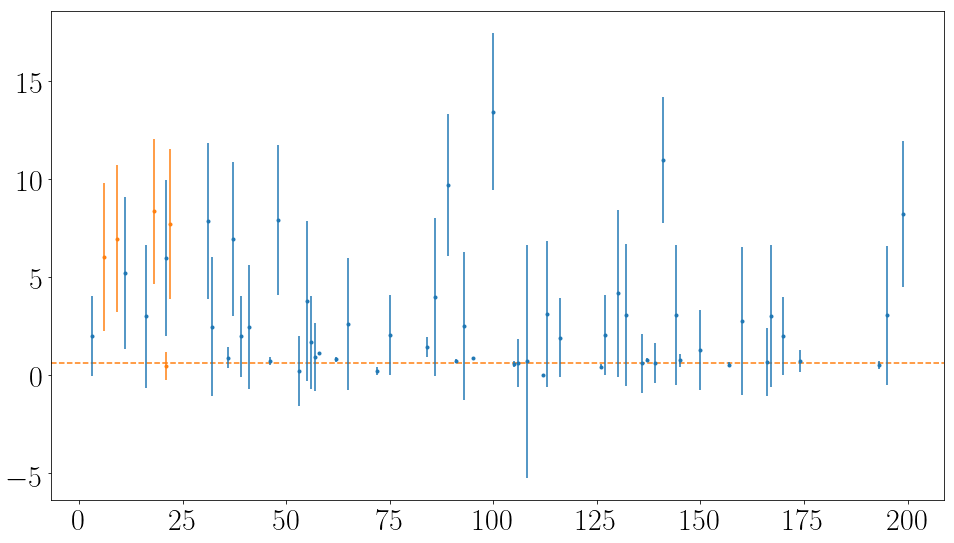

In [454]:
plt.figure(figsize=(16, 9))
plt.axhline(0.65, color="C1", ls="--", zorder=0)
for i, j in enumerate(pdf.i.values):
    plt.errorbar(j, pdf.age.values[i], yerr=pdf.age_err.values[i], fmt=".", color="C0", zorder=1)
    
for i, j in enumerate(idf.i.values):
    plt.errorbar(j, idf.age.values[i], yerr=idf.age_err.values[i], fmt=".", color="C1", zorder=1)
# plt.errorbar(np.arange(len(idf)), idf.age, yerr=[idf.age_errp, idf.age_errm], fmt=".", zorder=1)

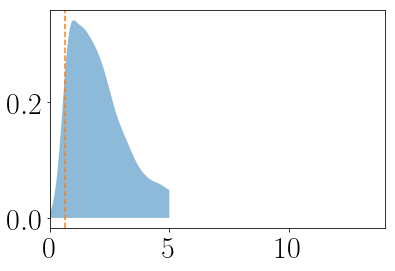

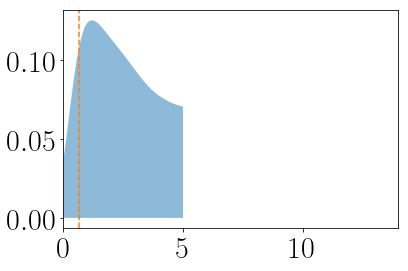

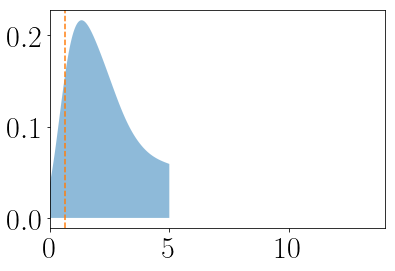

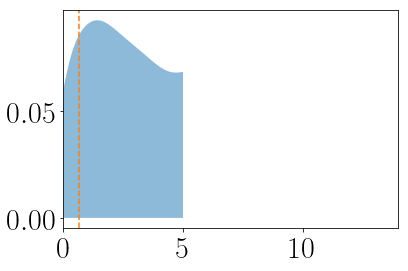

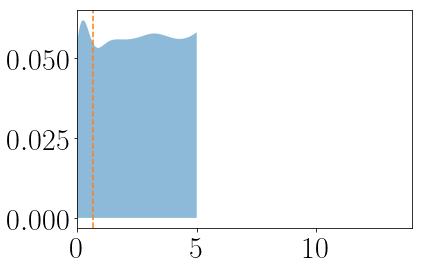

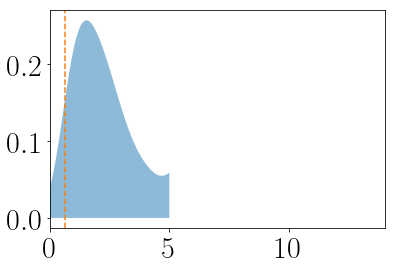

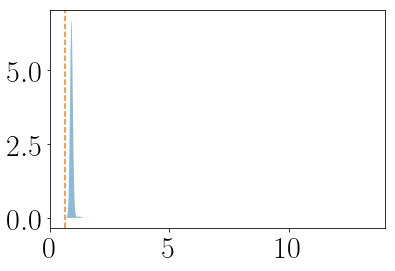

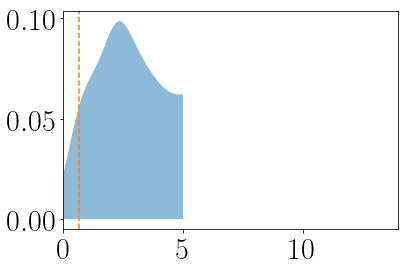

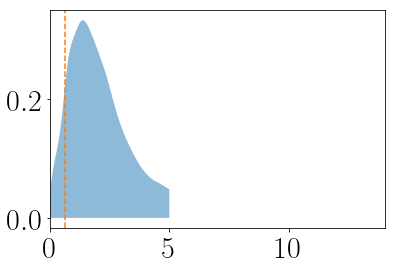

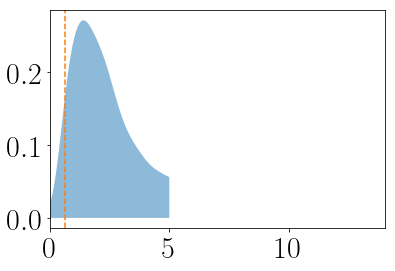

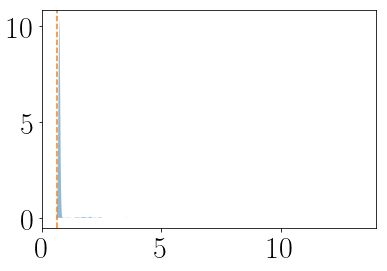

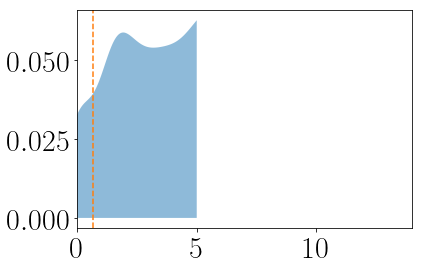

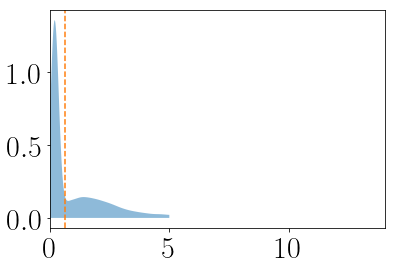

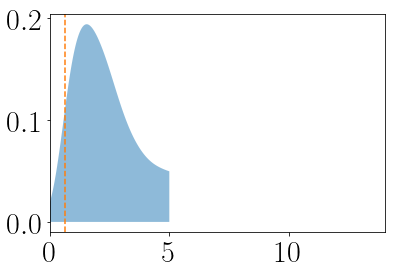

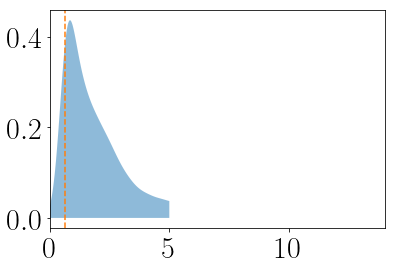

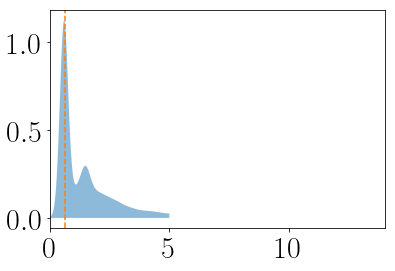

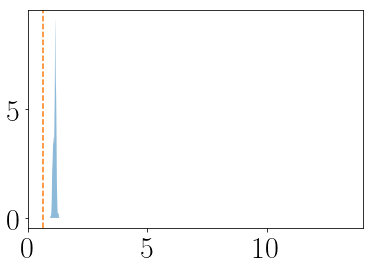

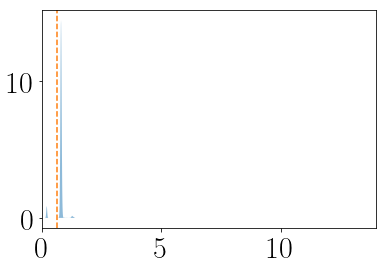

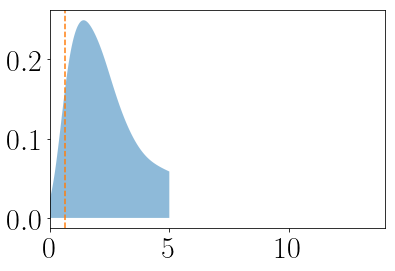

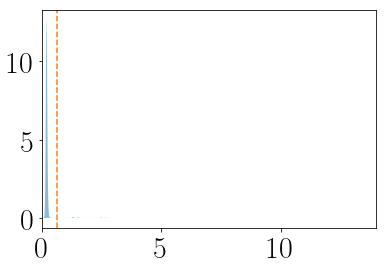

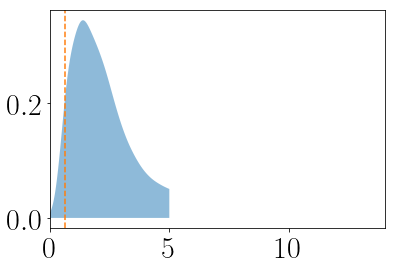

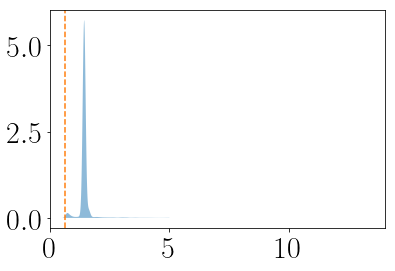

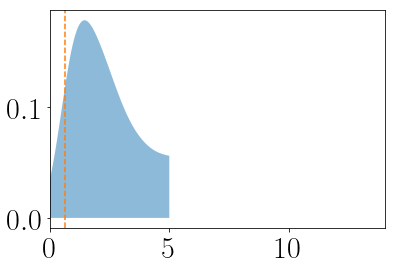

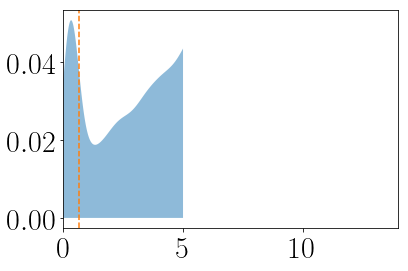

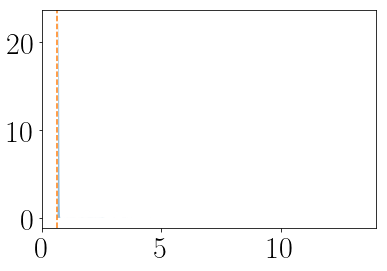

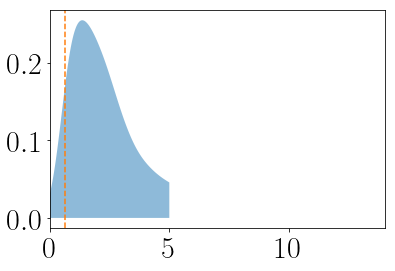

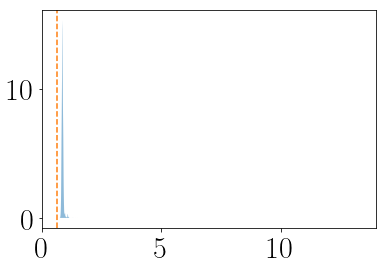

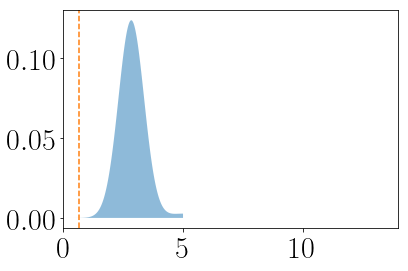

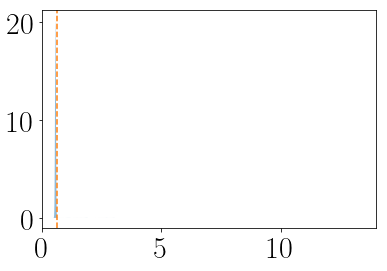

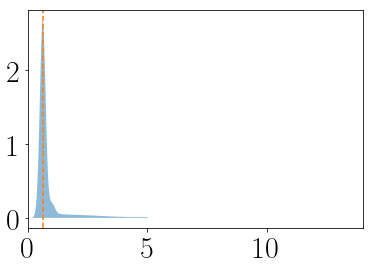

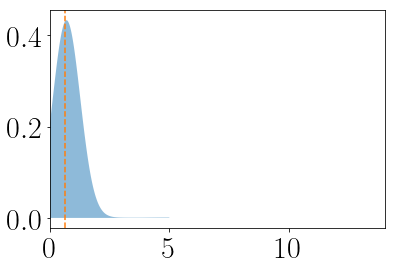

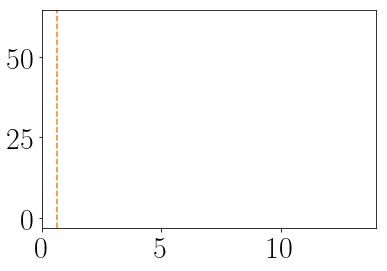

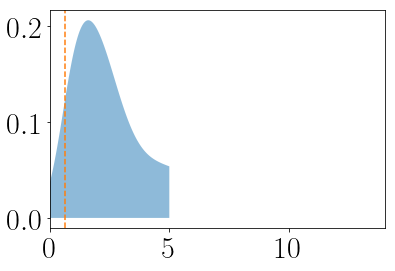

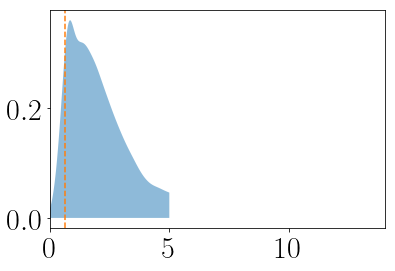

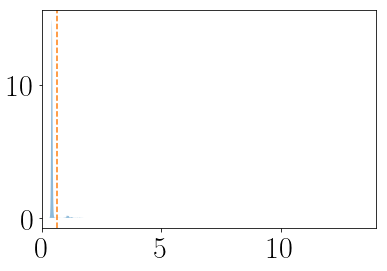

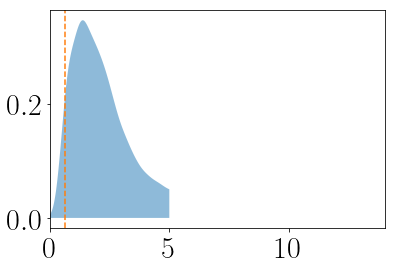

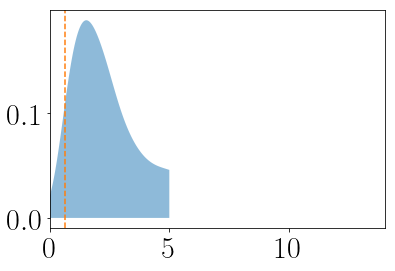

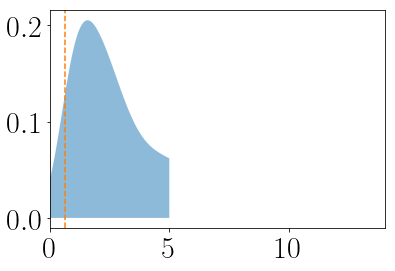

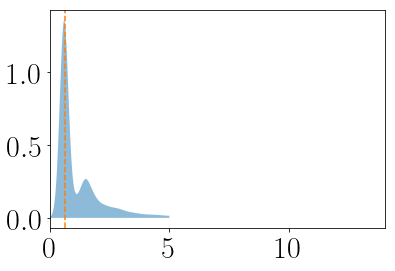

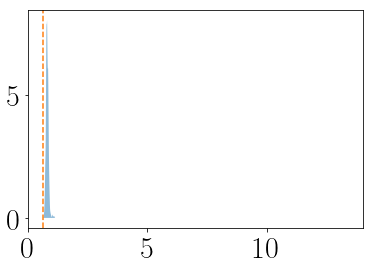

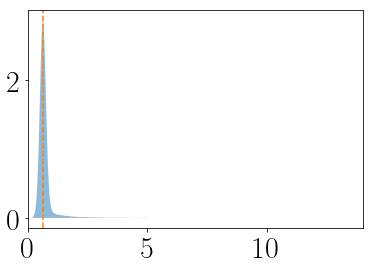

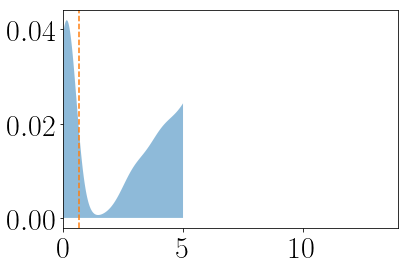

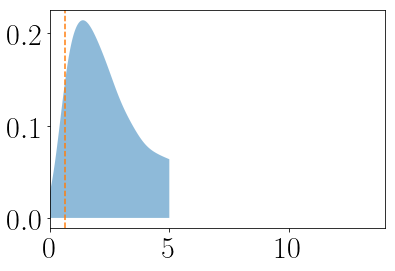

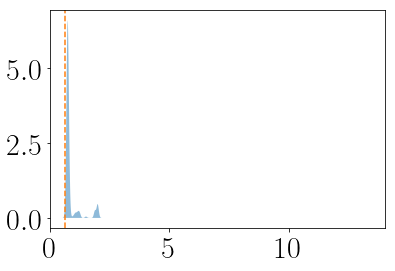

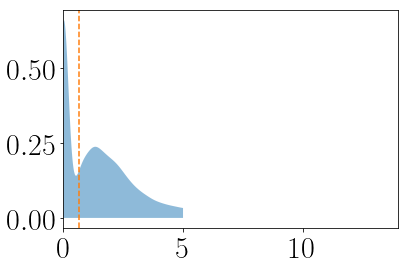

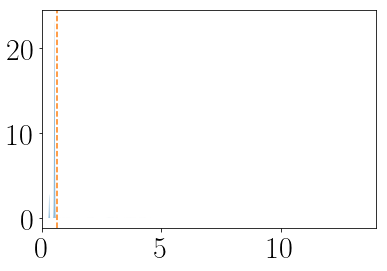

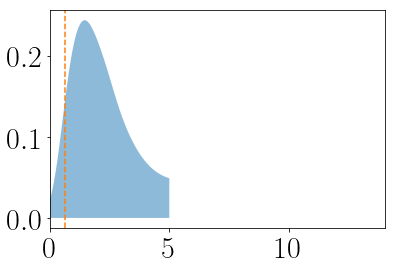

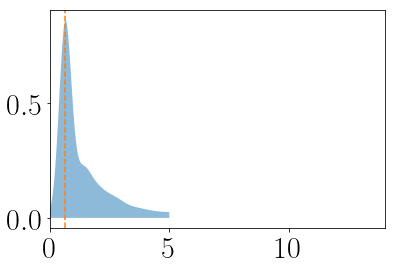

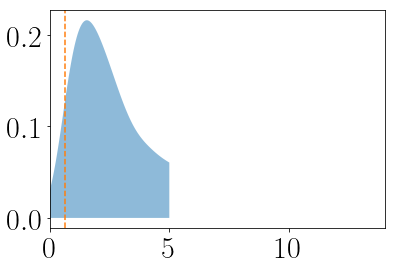

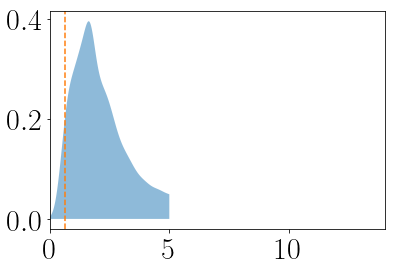

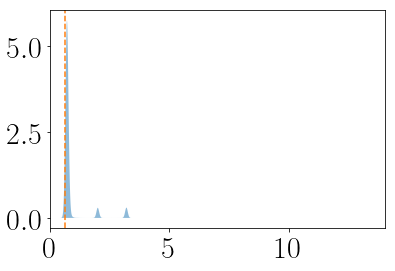

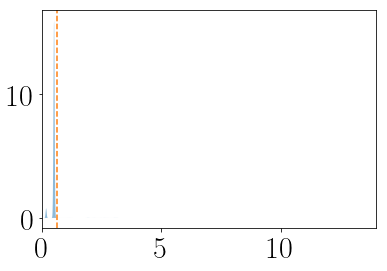

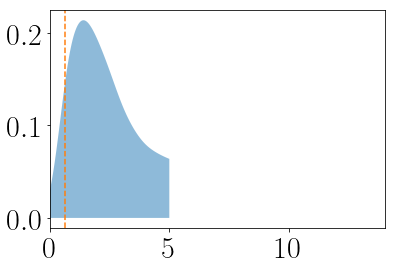

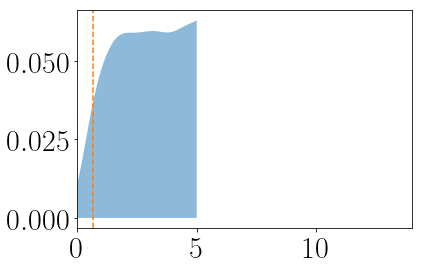

In [456]:
for i in pdf.i.values:
    kernel = sps.gaussian_kde(np.array(page_samps[i]))
    
    plt.subplot(1, 2, 1)
    plt.fill_between(xs, 0, kernel(xs), alpha=.5)
    plt.axvline(.65, color="C1", ls="--")
    plt.xlim(0, 14)
    
    plt.subplot(1, 2, 2)
    plt.show()

2.0523015832751508


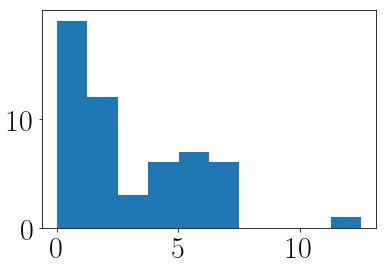

In [439]:
plt.hist(pdf.age_errp);
print(np.median(pdf.age_err))

0.008482478161804616


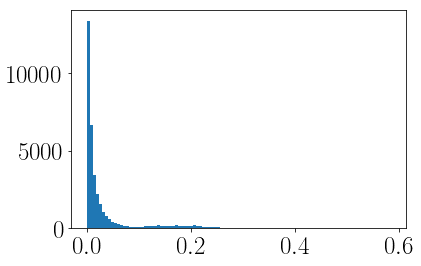

In [622]:
mc = pd.read_csv("data/Table_1_Periodic.txt")
plt.hist(mc.Prot_err/mc.Prot, 100);
print(np.median(mc.Prot_err/mc.Prot))
# plt.xlim(0, 25)

-2.0700714664284288
0.008509979885502093


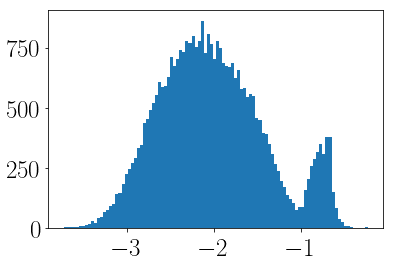

In [624]:
m = np.isfinite(mc.Prot_err/mc.Prot) * (mc.Prot_err/mc.Prot > 0.)
plt.hist(np.log10(mc.Prot_err[m]/mc.Prot[m]), 100);
print(np.median(np.log10(mc.Prot_err[m]/mc.Prot[m])))
print(10**np.median(np.log10(mc.Prot_err[m]/mc.Prot[m])))

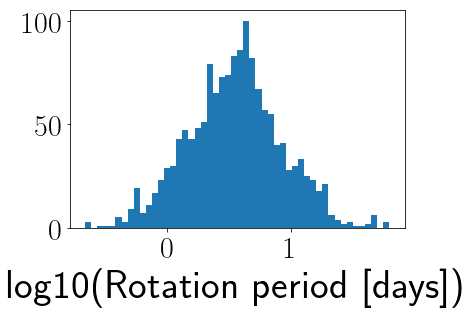

In [574]:
plt.hist(np.log10(mc.Prot.values[mc.Teff.values > 6250]), 50);
plt.xlabel("log10(Rotation period [days])")
plt.savefig("/Users/rangus/Desktop/period_distribution")

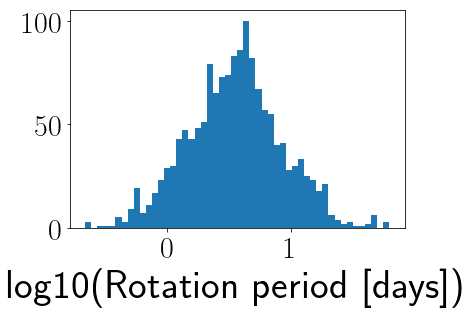

In [575]:
import pandas as pd
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
plt.hist(np.log10(mc.Prot.values[mc.Teff.values > 6250]), 50);
plt.xlabel("log10(Rotation period [days])")

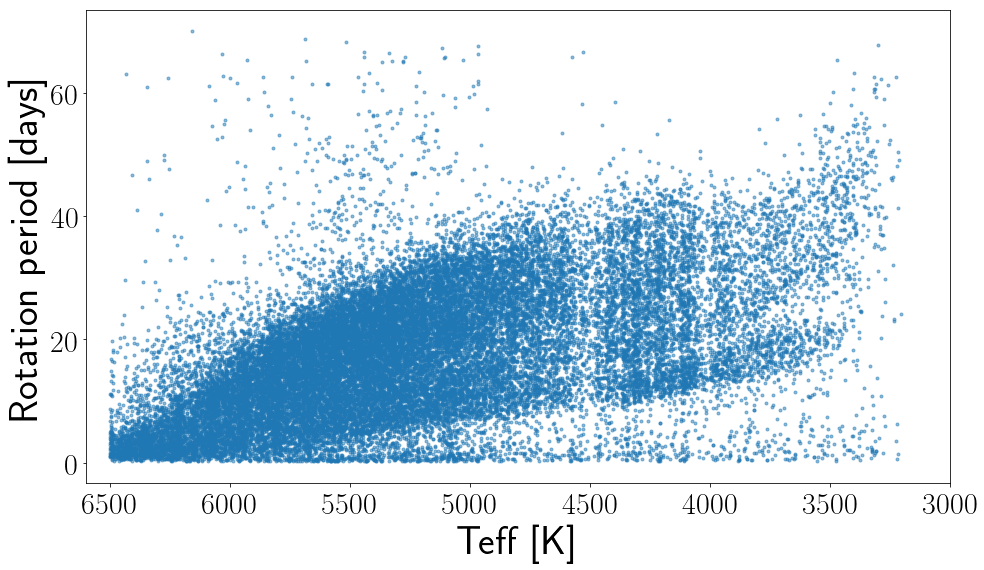

In [587]:
plt.figure(figsize=(16, 9))
plt.plot(mc.Teff, mc.Prot, ".", alpha=.5)
plt.xlim(6600, 3000)
plt.xlabel("Teff [K]")
plt.ylabel("Rotation period [days]")
plt.subplots_adjust(left=.15, bottom=.15)
plt.savefig("/Users/rangus/Desktop/period_teff")

In [200]:
def dist_mod(D):
    # m-M = 5*np.log10(D) - 5
    return 5*np.log10(D) - 5

print(dist_mod(1000))

10.0


In [203]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"teff": (5777, 10),     # Teff with uncertainty.
              "logg": (4.44, .05),    # logg with uncertainty.
              "feh": (0., .001),      # Metallicity with uncertainty.
              "parallax": (1., .01),  # Parallax in milliarcseconds.
              "B": (15.48, 0.02),     # You must provide at least one magnitude.
              "maxAV": .1}            # Maximum extinction

prot, prot_err = 26, 1

# Set up the star object.
star = sd.Star(iso_params, prot=prot, prot_err=prot_err)  # Here's where you add a rotation period

# Run the MCMC
star.fit(max_n=10000)

# Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results()
print("stellar age = {0} + {1} + {2}".format(age, errp, errm))

100%|██████████| 10000/10000 [01:13<00:00, 136.49it/s]

stellar age = 9.68645784464682 + 0.06717484438289034 + 0.08389554242028119
